# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 8 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/100, Loss: 0.8280
Epoch 1/200, Iteration 2/100, Loss: 1.0039
Epoch 1/200, Iteration 3/100, Loss: 1.4358
Epoch 1/200, Iteration 4/100, Loss: 1.0981
Epoch 1/200, Iteration 5/100, Loss: 1.9808
Epoch 1/200, Iteration 6/100, Loss: 0.9765
Epoch 1/200, Iteration 7/100, Loss: 0.6156
Epoch 1/200, Iteration 8/100, Loss: 0.8055
Epoch 1/200, Iteration 9/100, Loss: 0.6327
Epoch 1/200, Iteration 10/100, Loss: 0.8677
Epoch 1/200, Iteration 11/100, Loss: 0.7724
Epoch 1/200, Iteration 12/100, Loss: 1.0651
Epoch 1/200, Iteration 13/100, Loss: 0.8243
Epoch 1/200, Iteration 14/100, Loss: 0.7637
Epoch 1/200, Iteration 15/100, Loss: 0.4962
Epoch 1/200, Iteration 16/100, Loss: 0.8026
Epoch 1/200, Iteration 17/100, Loss: 0.6953
Epoch 1/200, Iteration 18/100, Loss: 1.0058
Epoch 1/200, Iteration 19/100, Loss: 0.7323
Epoch 1/200, Iteration 20/100, Loss: 0.7736
Epoch 1/200, Iteration 21/100, Loss: 0.5449
Epoch 1/200, Iteration 22/100, Loss: 0.5368
Epoch 1/200, Iteration 23/100, Loss: 0.54

Train Error: 
 Accuracy: 67.5%, Avg loss: 0.480939, MRE: 0.324953, MAE: 0.066799 

Test Error: 
 Accuracy: 69.0%, Avg loss: 0.444052, MRE: 0.283491, MAE: 0.061644 

Epoch 3/200, Iteration 1/100, Loss: 0.5392
Epoch 3/200, Iteration 2/100, Loss: 0.5677
Epoch 3/200, Iteration 3/100, Loss: 0.5270
Epoch 3/200, Iteration 4/100, Loss: 0.3606
Epoch 3/200, Iteration 5/100, Loss: 0.2851
Epoch 3/200, Iteration 6/100, Loss: 0.4427
Epoch 3/200, Iteration 7/100, Loss: 0.3773
Epoch 3/200, Iteration 8/100, Loss: 0.2027
Epoch 3/200, Iteration 9/100, Loss: 0.3849
Epoch 3/200, Iteration 10/100, Loss: 0.2483
Epoch 3/200, Iteration 11/100, Loss: 0.3413
Epoch 3/200, Iteration 12/100, Loss: 0.4444
Epoch 3/200, Iteration 13/100, Loss: 0.4751
Epoch 3/200, Iteration 14/100, Loss: 0.2922
Epoch 3/200, Iteration 15/100, Loss: 0.3706
Epoch 3/200, Iteration 16/100, Loss: 0.3364
Epoch 3/200, Iteration 17/100, Loss: 0.3845
Epoch 3/200, Iteration 18/100, Loss: 0.3474
Epoch 3/200, Iteration 19/100, Loss: 0.3652
Epoch 3/

Epoch 4/200, Iteration 87/100, Loss: 0.4351
Epoch 4/200, Iteration 88/100, Loss: 0.5839
Epoch 4/200, Iteration 89/100, Loss: 0.4869
Epoch 4/200, Iteration 90/100, Loss: 0.3703
Epoch 4/200, Iteration 91/100, Loss: 0.2137
Epoch 4/200, Iteration 92/100, Loss: 0.3590
Epoch 4/200, Iteration 93/100, Loss: 0.3533
Epoch 4/200, Iteration 94/100, Loss: 0.3546
Epoch 4/200, Iteration 95/100, Loss: 0.3652
Epoch 4/200, Iteration 96/100, Loss: 0.5803
Epoch 4/200, Iteration 97/100, Loss: 0.4954
Epoch 4/200, Iteration 98/100, Loss: 0.3786
Epoch 4/200, Iteration 99/100, Loss: 0.3309
Epoch 4/200, Iteration 100/100, Loss: 0.2840
Train Error: 
 Accuracy: 53.75%, Avg loss: 0.305199, MRE: 0.222547, MAE: 0.038360 

Test Error: 
 Accuracy: 52.5%, Avg loss: 0.286537, MRE: 0.204776, MAE: 0.036475 

Epoch 5/200, Iteration 1/100, Loss: 0.2723
Epoch 5/200, Iteration 2/100, Loss: 0.1857
Epoch 5/200, Iteration 3/100, Loss: 0.3847
Epoch 5/200, Iteration 4/100, Loss: 0.6082
Epoch 5/200, Iteration 5/100, Loss: 0.2895
Ep

Epoch 6/200, Iteration 90/100, Loss: 0.2707
Epoch 6/200, Iteration 91/100, Loss: 0.4288
Epoch 6/200, Iteration 92/100, Loss: 0.3551
Epoch 6/200, Iteration 93/100, Loss: 0.3317
Epoch 6/200, Iteration 94/100, Loss: 0.2412
Epoch 6/200, Iteration 95/100, Loss: 0.3621
Epoch 6/200, Iteration 96/100, Loss: 0.2523
Epoch 6/200, Iteration 97/100, Loss: 0.2952
Epoch 6/200, Iteration 98/100, Loss: 0.3574
Epoch 6/200, Iteration 99/100, Loss: 0.3421
Epoch 6/200, Iteration 100/100, Loss: 0.1754
Train Error: 
 Accuracy: 21.12%, Avg loss: 0.386163, MRE: 0.322058, MAE: 0.053933 

Test Error: 
 Accuracy: 23.0%, Avg loss: 0.404011, MRE: 0.306057, MAE: 0.056240 

Epoch 7/200, Iteration 1/100, Loss: 0.4053
Epoch 7/200, Iteration 2/100, Loss: 0.2970
Epoch 7/200, Iteration 3/100, Loss: 0.3403
Epoch 7/200, Iteration 4/100, Loss: 0.2909
Epoch 7/200, Iteration 5/100, Loss: 0.5336
Epoch 7/200, Iteration 6/100, Loss: 0.4008
Epoch 7/200, Iteration 7/100, Loss: 0.5613
Epoch 7/200, Iteration 8/100, Loss: 0.3588
Epoch

Epoch 8/200, Iteration 78/100, Loss: 0.3723
Epoch 8/200, Iteration 79/100, Loss: 0.4776
Epoch 8/200, Iteration 80/100, Loss: 0.4950
Epoch 8/200, Iteration 81/100, Loss: 0.4357
Epoch 8/200, Iteration 82/100, Loss: 0.2058
Epoch 8/200, Iteration 83/100, Loss: 0.4895
Epoch 8/200, Iteration 84/100, Loss: 0.3927
Epoch 8/200, Iteration 85/100, Loss: 0.3686
Epoch 8/200, Iteration 86/100, Loss: 0.3088
Epoch 8/200, Iteration 87/100, Loss: 0.4383
Epoch 8/200, Iteration 88/100, Loss: 0.3671
Epoch 8/200, Iteration 89/100, Loss: 0.2648
Epoch 8/200, Iteration 90/100, Loss: 0.3193
Epoch 8/200, Iteration 91/100, Loss: 0.2872
Epoch 8/200, Iteration 92/100, Loss: 0.3151
Epoch 8/200, Iteration 93/100, Loss: 0.2202
Epoch 8/200, Iteration 94/100, Loss: 0.2282
Epoch 8/200, Iteration 95/100, Loss: 0.2302
Epoch 8/200, Iteration 96/100, Loss: 0.3814
Epoch 8/200, Iteration 97/100, Loss: 0.3069
Epoch 8/200, Iteration 98/100, Loss: 0.4020
Epoch 8/200, Iteration 99/100, Loss: 0.4283
Epoch 8/200, Iteration 100/100, 

Epoch 10/200, Iteration 61/100, Loss: 0.3183
Epoch 10/200, Iteration 62/100, Loss: 0.2086
Epoch 10/200, Iteration 63/100, Loss: 0.2799
Epoch 10/200, Iteration 64/100, Loss: 0.3060
Epoch 10/200, Iteration 65/100, Loss: 0.2838
Epoch 10/200, Iteration 66/100, Loss: 0.2924
Epoch 10/200, Iteration 67/100, Loss: 0.2824
Epoch 10/200, Iteration 68/100, Loss: 0.2365
Epoch 10/200, Iteration 69/100, Loss: 0.3713
Epoch 10/200, Iteration 70/100, Loss: 0.2211
Epoch 10/200, Iteration 71/100, Loss: 0.1935
Epoch 10/200, Iteration 72/100, Loss: 0.3454
Epoch 10/200, Iteration 73/100, Loss: 0.2051
Epoch 10/200, Iteration 74/100, Loss: 0.2283
Epoch 10/200, Iteration 75/100, Loss: 0.2865
Epoch 10/200, Iteration 76/100, Loss: 0.4102
Epoch 10/200, Iteration 77/100, Loss: 0.2966
Epoch 10/200, Iteration 78/100, Loss: 0.1578
Epoch 10/200, Iteration 79/100, Loss: 0.4782
Epoch 10/200, Iteration 80/100, Loss: 0.4904
Epoch 10/200, Iteration 81/100, Loss: 0.5139
Epoch 10/200, Iteration 82/100, Loss: 0.2798
Epoch 10/2

Epoch 12/200, Iteration 54/100, Loss: 0.2690
Epoch 12/200, Iteration 55/100, Loss: 0.1693
Epoch 12/200, Iteration 56/100, Loss: 0.1397
Epoch 12/200, Iteration 57/100, Loss: 0.1667
Epoch 12/200, Iteration 58/100, Loss: 0.1713
Epoch 12/200, Iteration 59/100, Loss: 0.1533
Epoch 12/200, Iteration 60/100, Loss: 0.2756
Epoch 12/200, Iteration 61/100, Loss: 0.3229
Epoch 12/200, Iteration 62/100, Loss: 0.1538
Epoch 12/200, Iteration 63/100, Loss: 0.3013
Epoch 12/200, Iteration 64/100, Loss: 0.3325
Epoch 12/200, Iteration 65/100, Loss: 0.2315
Epoch 12/200, Iteration 66/100, Loss: 0.1701
Epoch 12/200, Iteration 67/100, Loss: 0.2759
Epoch 12/200, Iteration 68/100, Loss: 0.3439
Epoch 12/200, Iteration 69/100, Loss: 0.2824
Epoch 12/200, Iteration 70/100, Loss: 0.4245
Epoch 12/200, Iteration 71/100, Loss: 0.2801
Epoch 12/200, Iteration 72/100, Loss: 0.2039
Epoch 12/200, Iteration 73/100, Loss: 0.3225
Epoch 12/200, Iteration 74/100, Loss: 0.3426
Epoch 12/200, Iteration 75/100, Loss: 0.2813
Epoch 12/2

Epoch 14/200, Iteration 43/100, Loss: 0.4117
Epoch 14/200, Iteration 44/100, Loss: 0.2747
Epoch 14/200, Iteration 45/100, Loss: 0.3095
Epoch 14/200, Iteration 46/100, Loss: 0.3653
Epoch 14/200, Iteration 47/100, Loss: 0.2209
Epoch 14/200, Iteration 48/100, Loss: 0.3612
Epoch 14/200, Iteration 49/100, Loss: 0.5633
Epoch 14/200, Iteration 50/100, Loss: 0.4406
Epoch 14/200, Iteration 51/100, Loss: 0.2419
Epoch 14/200, Iteration 52/100, Loss: 0.2283
Epoch 14/200, Iteration 53/100, Loss: 0.3535
Epoch 14/200, Iteration 54/100, Loss: 0.3772
Epoch 14/200, Iteration 55/100, Loss: 0.3450
Epoch 14/200, Iteration 56/100, Loss: 0.2771
Epoch 14/200, Iteration 57/100, Loss: 0.4130
Epoch 14/200, Iteration 58/100, Loss: 0.3335
Epoch 14/200, Iteration 59/100, Loss: 0.3908
Epoch 14/200, Iteration 60/100, Loss: 0.2222
Epoch 14/200, Iteration 61/100, Loss: 0.2668
Epoch 14/200, Iteration 62/100, Loss: 0.3092
Epoch 14/200, Iteration 63/100, Loss: 0.3373
Epoch 14/200, Iteration 64/100, Loss: 0.3278
Epoch 14/2

Epoch 16/200, Iteration 50/100, Loss: 0.4537
Epoch 16/200, Iteration 51/100, Loss: 0.4390
Epoch 16/200, Iteration 52/100, Loss: 0.3409
Epoch 16/200, Iteration 53/100, Loss: 0.3209
Epoch 16/200, Iteration 54/100, Loss: 0.4283
Epoch 16/200, Iteration 55/100, Loss: 0.3589
Epoch 16/200, Iteration 56/100, Loss: 0.3430
Epoch 16/200, Iteration 57/100, Loss: 0.4750
Epoch 16/200, Iteration 58/100, Loss: 0.3679
Epoch 16/200, Iteration 59/100, Loss: 0.5269
Epoch 16/200, Iteration 60/100, Loss: 0.3285
Epoch 16/200, Iteration 61/100, Loss: 0.3036
Epoch 16/200, Iteration 62/100, Loss: 0.3380
Epoch 16/200, Iteration 63/100, Loss: 0.3012
Epoch 16/200, Iteration 64/100, Loss: 0.3023
Epoch 16/200, Iteration 65/100, Loss: 0.3309
Epoch 16/200, Iteration 66/100, Loss: 0.4462
Epoch 16/200, Iteration 67/100, Loss: 0.3135
Epoch 16/200, Iteration 68/100, Loss: 0.3064
Epoch 16/200, Iteration 69/100, Loss: 0.3846
Epoch 16/200, Iteration 70/100, Loss: 0.4863
Epoch 16/200, Iteration 71/100, Loss: 0.2218
Epoch 16/2

Epoch 18/200, Iteration 54/100, Loss: 0.3495
Epoch 18/200, Iteration 55/100, Loss: 0.3037
Epoch 18/200, Iteration 56/100, Loss: 0.2103
Epoch 18/200, Iteration 57/100, Loss: 0.3751
Epoch 18/200, Iteration 58/100, Loss: 0.2389
Epoch 18/200, Iteration 59/100, Loss: 0.2296
Epoch 18/200, Iteration 60/100, Loss: 0.2380
Epoch 18/200, Iteration 61/100, Loss: 0.3472
Epoch 18/200, Iteration 62/100, Loss: 0.3101
Epoch 18/200, Iteration 63/100, Loss: 0.4404
Epoch 18/200, Iteration 64/100, Loss: 0.3186
Epoch 18/200, Iteration 65/100, Loss: 0.2152
Epoch 18/200, Iteration 66/100, Loss: 0.3265
Epoch 18/200, Iteration 67/100, Loss: 0.4495
Epoch 18/200, Iteration 68/100, Loss: 0.2804
Epoch 18/200, Iteration 69/100, Loss: 0.3711
Epoch 18/200, Iteration 70/100, Loss: 0.5802
Epoch 18/200, Iteration 71/100, Loss: 0.2954
Epoch 18/200, Iteration 72/100, Loss: 0.2306
Epoch 18/200, Iteration 73/100, Loss: 0.3816
Epoch 18/200, Iteration 74/100, Loss: 0.4397
Epoch 18/200, Iteration 75/100, Loss: 0.2853
Epoch 18/2

Epoch 20/200, Iteration 50/100, Loss: 0.4661
Epoch 20/200, Iteration 51/100, Loss: 0.4709
Epoch 20/200, Iteration 52/100, Loss: 0.2752
Epoch 20/200, Iteration 53/100, Loss: 0.3017
Epoch 20/200, Iteration 54/100, Loss: 0.4072
Epoch 20/200, Iteration 55/100, Loss: 0.2425
Epoch 20/200, Iteration 56/100, Loss: 0.3800
Epoch 20/200, Iteration 57/100, Loss: 0.3994
Epoch 20/200, Iteration 58/100, Loss: 0.2720
Epoch 20/200, Iteration 59/100, Loss: 0.2745
Epoch 20/200, Iteration 60/100, Loss: 0.3569
Epoch 20/200, Iteration 61/100, Loss: 0.2851
Epoch 20/200, Iteration 62/100, Loss: 0.3473
Epoch 20/200, Iteration 63/100, Loss: 0.3012
Epoch 20/200, Iteration 64/100, Loss: 0.2667
Epoch 20/200, Iteration 65/100, Loss: 0.2882
Epoch 20/200, Iteration 66/100, Loss: 0.4055
Epoch 20/200, Iteration 67/100, Loss: 0.3177
Epoch 20/200, Iteration 68/100, Loss: 0.2930
Epoch 20/200, Iteration 69/100, Loss: 0.2199
Epoch 20/200, Iteration 70/100, Loss: 0.2759
Epoch 20/200, Iteration 71/100, Loss: 0.2482
Epoch 20/2

Epoch 22/200, Iteration 45/100, Loss: 0.1864
Epoch 22/200, Iteration 46/100, Loss: 0.1777
Epoch 22/200, Iteration 47/100, Loss: 0.2045
Epoch 22/200, Iteration 48/100, Loss: 0.1789
Epoch 22/200, Iteration 49/100, Loss: 0.2180
Epoch 22/200, Iteration 50/100, Loss: 0.1495
Epoch 22/200, Iteration 51/100, Loss: 0.1412
Epoch 22/200, Iteration 52/100, Loss: 0.1801
Epoch 22/200, Iteration 53/100, Loss: 0.2436
Epoch 22/200, Iteration 54/100, Loss: 0.1275
Epoch 22/200, Iteration 55/100, Loss: 0.1584
Epoch 22/200, Iteration 56/100, Loss: 0.1911
Epoch 22/200, Iteration 57/100, Loss: 0.1897
Epoch 22/200, Iteration 58/100, Loss: 0.1032
Epoch 22/200, Iteration 59/100, Loss: 0.3295
Epoch 22/200, Iteration 60/100, Loss: 0.1894
Epoch 22/200, Iteration 61/100, Loss: 0.1238
Epoch 22/200, Iteration 62/100, Loss: 0.2816
Epoch 22/200, Iteration 63/100, Loss: 0.2994
Epoch 22/200, Iteration 64/100, Loss: 0.1226
Epoch 22/200, Iteration 65/100, Loss: 0.1778
Epoch 22/200, Iteration 66/100, Loss: 0.1477
Epoch 22/2

Epoch 24/200, Iteration 44/100, Loss: 0.1492
Epoch 24/200, Iteration 45/100, Loss: 0.2197
Epoch 24/200, Iteration 46/100, Loss: 0.1304
Epoch 24/200, Iteration 47/100, Loss: 0.1118
Epoch 24/200, Iteration 48/100, Loss: 0.1418
Epoch 24/200, Iteration 49/100, Loss: 0.1366
Epoch 24/200, Iteration 50/100, Loss: 0.1956
Epoch 24/200, Iteration 51/100, Loss: 0.1268
Epoch 24/200, Iteration 52/100, Loss: 0.1084
Epoch 24/200, Iteration 53/100, Loss: 0.1004
Epoch 24/200, Iteration 54/100, Loss: 0.1633
Epoch 24/200, Iteration 55/100, Loss: 0.1429
Epoch 24/200, Iteration 56/100, Loss: 0.1236
Epoch 24/200, Iteration 57/100, Loss: 0.1940
Epoch 24/200, Iteration 58/100, Loss: 0.2343
Epoch 24/200, Iteration 59/100, Loss: 0.0936
Epoch 24/200, Iteration 60/100, Loss: 0.1387
Epoch 24/200, Iteration 61/100, Loss: 0.2311
Epoch 24/200, Iteration 62/100, Loss: 0.1285
Epoch 24/200, Iteration 63/100, Loss: 0.1671
Epoch 24/200, Iteration 64/100, Loss: 0.2159
Epoch 24/200, Iteration 65/100, Loss: 0.1910
Epoch 24/2

Epoch 26/200, Iteration 45/100, Loss: 0.0929
Epoch 26/200, Iteration 46/100, Loss: 0.1787
Epoch 26/200, Iteration 47/100, Loss: 0.0724
Epoch 26/200, Iteration 48/100, Loss: 0.1208
Epoch 26/200, Iteration 49/100, Loss: 0.2022
Epoch 26/200, Iteration 50/100, Loss: 0.0868
Epoch 26/200, Iteration 51/100, Loss: 0.1123
Epoch 26/200, Iteration 52/100, Loss: 0.1410
Epoch 26/200, Iteration 53/100, Loss: 0.1537
Epoch 26/200, Iteration 54/100, Loss: 0.1016
Epoch 26/200, Iteration 55/100, Loss: 0.1295
Epoch 26/200, Iteration 56/100, Loss: 0.1915
Epoch 26/200, Iteration 57/100, Loss: 0.1113
Epoch 26/200, Iteration 58/100, Loss: 0.1505
Epoch 26/200, Iteration 59/100, Loss: 0.1210
Epoch 26/200, Iteration 60/100, Loss: 0.0758
Epoch 26/200, Iteration 61/100, Loss: 0.0967
Epoch 26/200, Iteration 62/100, Loss: 0.0858
Epoch 26/200, Iteration 63/100, Loss: 0.1977
Epoch 26/200, Iteration 64/100, Loss: 0.1989
Epoch 26/200, Iteration 65/100, Loss: 0.1424
Epoch 26/200, Iteration 66/100, Loss: 0.0812
Epoch 26/2

Epoch 28/200, Iteration 46/100, Loss: 0.1072
Epoch 28/200, Iteration 47/100, Loss: 0.1270
Epoch 28/200, Iteration 48/100, Loss: 0.1078
Epoch 28/200, Iteration 49/100, Loss: 0.1156
Epoch 28/200, Iteration 50/100, Loss: 0.1337
Epoch 28/200, Iteration 51/100, Loss: 0.0883
Epoch 28/200, Iteration 52/100, Loss: 0.1628
Epoch 28/200, Iteration 53/100, Loss: 0.1067
Epoch 28/200, Iteration 54/100, Loss: 0.1411
Epoch 28/200, Iteration 55/100, Loss: 0.1479
Epoch 28/200, Iteration 56/100, Loss: 0.1274
Epoch 28/200, Iteration 57/100, Loss: 0.1472
Epoch 28/200, Iteration 58/100, Loss: 0.1113
Epoch 28/200, Iteration 59/100, Loss: 0.1165
Epoch 28/200, Iteration 60/100, Loss: 0.1540
Epoch 28/200, Iteration 61/100, Loss: 0.1386
Epoch 28/200, Iteration 62/100, Loss: 0.0830
Epoch 28/200, Iteration 63/100, Loss: 0.1355
Epoch 28/200, Iteration 64/100, Loss: 0.1320
Epoch 28/200, Iteration 65/100, Loss: 0.1111
Epoch 28/200, Iteration 66/100, Loss: 0.1391
Epoch 28/200, Iteration 67/100, Loss: 0.1648
Epoch 28/2

Epoch 30/200, Iteration 44/100, Loss: 0.0769
Epoch 30/200, Iteration 45/100, Loss: 0.1281
Epoch 30/200, Iteration 46/100, Loss: 0.1012
Epoch 30/200, Iteration 47/100, Loss: 0.1422
Epoch 30/200, Iteration 48/100, Loss: 0.0793
Epoch 30/200, Iteration 49/100, Loss: 0.0910
Epoch 30/200, Iteration 50/100, Loss: 0.0870
Epoch 30/200, Iteration 51/100, Loss: 0.1007
Epoch 30/200, Iteration 52/100, Loss: 0.1506
Epoch 30/200, Iteration 53/100, Loss: 0.0896
Epoch 30/200, Iteration 54/100, Loss: 0.0933
Epoch 30/200, Iteration 55/100, Loss: 0.0907
Epoch 30/200, Iteration 56/100, Loss: 0.1486
Epoch 30/200, Iteration 57/100, Loss: 0.0955
Epoch 30/200, Iteration 58/100, Loss: 0.1672
Epoch 30/200, Iteration 59/100, Loss: 0.1328
Epoch 30/200, Iteration 60/100, Loss: 0.1484
Epoch 30/200, Iteration 61/100, Loss: 0.0993
Epoch 30/200, Iteration 62/100, Loss: 0.0886
Epoch 30/200, Iteration 63/100, Loss: 0.1150
Epoch 30/200, Iteration 64/100, Loss: 0.0935
Epoch 30/200, Iteration 65/100, Loss: 0.0563
Epoch 30/2

Epoch 32/200, Iteration 38/100, Loss: 0.1072
Epoch 32/200, Iteration 39/100, Loss: 0.0599
Epoch 32/200, Iteration 40/100, Loss: 0.1093
Epoch 32/200, Iteration 41/100, Loss: 0.1009
Epoch 32/200, Iteration 42/100, Loss: 0.1244
Epoch 32/200, Iteration 43/100, Loss: 0.1373
Epoch 32/200, Iteration 44/100, Loss: 0.1117
Epoch 32/200, Iteration 45/100, Loss: 0.1068
Epoch 32/200, Iteration 46/100, Loss: 0.1104
Epoch 32/200, Iteration 47/100, Loss: 0.1012
Epoch 32/200, Iteration 48/100, Loss: 0.0871
Epoch 32/200, Iteration 49/100, Loss: 0.1072
Epoch 32/200, Iteration 50/100, Loss: 0.1095
Epoch 32/200, Iteration 51/100, Loss: 0.0941
Epoch 32/200, Iteration 52/100, Loss: 0.1683
Epoch 32/200, Iteration 53/100, Loss: 0.1314
Epoch 32/200, Iteration 54/100, Loss: 0.1297
Epoch 32/200, Iteration 55/100, Loss: 0.0835
Epoch 32/200, Iteration 56/100, Loss: 0.0947
Epoch 32/200, Iteration 57/100, Loss: 0.1147
Epoch 32/200, Iteration 58/100, Loss: 0.1012
Epoch 32/200, Iteration 59/100, Loss: 0.0912
Epoch 32/2

Epoch 34/200, Iteration 34/100, Loss: 0.1356
Epoch 34/200, Iteration 35/100, Loss: 0.0826
Epoch 34/200, Iteration 36/100, Loss: 0.0692
Epoch 34/200, Iteration 37/100, Loss: 0.0748
Epoch 34/200, Iteration 38/100, Loss: 0.1203
Epoch 34/200, Iteration 39/100, Loss: 0.1186
Epoch 34/200, Iteration 40/100, Loss: 0.1701
Epoch 34/200, Iteration 41/100, Loss: 0.1491
Epoch 34/200, Iteration 42/100, Loss: 0.1146
Epoch 34/200, Iteration 43/100, Loss: 0.2236
Epoch 34/200, Iteration 44/100, Loss: 0.1170
Epoch 34/200, Iteration 45/100, Loss: 0.1175
Epoch 34/200, Iteration 46/100, Loss: 0.0769
Epoch 34/200, Iteration 47/100, Loss: 0.0503
Epoch 34/200, Iteration 48/100, Loss: 0.1174
Epoch 34/200, Iteration 49/100, Loss: 0.1277
Epoch 34/200, Iteration 50/100, Loss: 0.1412
Epoch 34/200, Iteration 51/100, Loss: 0.0917
Epoch 34/200, Iteration 52/100, Loss: 0.1202
Epoch 34/200, Iteration 53/100, Loss: 0.1067
Epoch 34/200, Iteration 54/100, Loss: 0.0898
Epoch 34/200, Iteration 55/100, Loss: 0.1355
Epoch 34/2

Epoch 36/200, Iteration 26/100, Loss: 0.0603
Epoch 36/200, Iteration 27/100, Loss: 0.0932
Epoch 36/200, Iteration 28/100, Loss: 0.1039
Epoch 36/200, Iteration 29/100, Loss: 0.1541
Epoch 36/200, Iteration 30/100, Loss: 0.0814
Epoch 36/200, Iteration 31/100, Loss: 0.0935
Epoch 36/200, Iteration 32/100, Loss: 0.0902
Epoch 36/200, Iteration 33/100, Loss: 0.0802
Epoch 36/200, Iteration 34/100, Loss: 0.1113
Epoch 36/200, Iteration 35/100, Loss: 0.1277
Epoch 36/200, Iteration 36/100, Loss: 0.1197
Epoch 36/200, Iteration 37/100, Loss: 0.0892
Epoch 36/200, Iteration 38/100, Loss: 0.1058
Epoch 36/200, Iteration 39/100, Loss: 0.1182
Epoch 36/200, Iteration 40/100, Loss: 0.1168
Epoch 36/200, Iteration 41/100, Loss: 0.1605
Epoch 36/200, Iteration 42/100, Loss: 0.0900
Epoch 36/200, Iteration 43/100, Loss: 0.0891
Epoch 36/200, Iteration 44/100, Loss: 0.1160
Epoch 36/200, Iteration 45/100, Loss: 0.1022
Epoch 36/200, Iteration 46/100, Loss: 0.0913
Epoch 36/200, Iteration 47/100, Loss: 0.1380
Epoch 36/2

Epoch 38/200, Iteration 4/100, Loss: 0.0815
Epoch 38/200, Iteration 5/100, Loss: 0.0768
Epoch 38/200, Iteration 6/100, Loss: 0.0702
Epoch 38/200, Iteration 7/100, Loss: 0.1097
Epoch 38/200, Iteration 8/100, Loss: 0.0890
Epoch 38/200, Iteration 9/100, Loss: 0.0951
Epoch 38/200, Iteration 10/100, Loss: 0.0972
Epoch 38/200, Iteration 11/100, Loss: 0.0815
Epoch 38/200, Iteration 12/100, Loss: 0.1028
Epoch 38/200, Iteration 13/100, Loss: 0.0837
Epoch 38/200, Iteration 14/100, Loss: 0.0809
Epoch 38/200, Iteration 15/100, Loss: 0.0787
Epoch 38/200, Iteration 16/100, Loss: 0.0886
Epoch 38/200, Iteration 17/100, Loss: 0.0866
Epoch 38/200, Iteration 18/100, Loss: 0.0677
Epoch 38/200, Iteration 19/100, Loss: 0.0851
Epoch 38/200, Iteration 20/100, Loss: 0.1175
Epoch 38/200, Iteration 21/100, Loss: 0.0876
Epoch 38/200, Iteration 22/100, Loss: 0.1190
Epoch 38/200, Iteration 23/100, Loss: 0.0879
Epoch 38/200, Iteration 24/100, Loss: 0.1210
Epoch 38/200, Iteration 25/100, Loss: 0.0992
Epoch 38/200, It

Train Error: 
 Accuracy: 84.25%, Avg loss: 0.098331, MRE: 0.066941, MAE: 0.013737 

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.110998, MRE: 0.069277, MAE: 0.015294 

Epoch 40/200, Iteration 1/100, Loss: 0.1058
Epoch 40/200, Iteration 2/100, Loss: 0.0986
Epoch 40/200, Iteration 3/100, Loss: 0.1217
Epoch 40/200, Iteration 4/100, Loss: 0.0636
Epoch 40/200, Iteration 5/100, Loss: 0.0960
Epoch 40/200, Iteration 6/100, Loss: 0.0955
Epoch 40/200, Iteration 7/100, Loss: 0.1167
Epoch 40/200, Iteration 8/100, Loss: 0.0674
Epoch 40/200, Iteration 9/100, Loss: 0.0972
Epoch 40/200, Iteration 10/100, Loss: 0.0544
Epoch 40/200, Iteration 11/100, Loss: 0.0792
Epoch 40/200, Iteration 12/100, Loss: 0.0853
Epoch 40/200, Iteration 13/100, Loss: 0.1420
Epoch 40/200, Iteration 14/100, Loss: 0.0953
Epoch 40/200, Iteration 15/100, Loss: 0.0929
Epoch 40/200, Iteration 16/100, Loss: 0.1016
Epoch 40/200, Iteration 17/100, Loss: 0.0592
Epoch 40/200, Iteration 18/100, Loss: 0.1346
Epoch 40/200, Iteration 19/100, L

Epoch 41/200, Iteration 91/100, Loss: 0.0759
Epoch 41/200, Iteration 92/100, Loss: 0.0818
Epoch 41/200, Iteration 93/100, Loss: 0.1108
Epoch 41/200, Iteration 94/100, Loss: 0.0833
Epoch 41/200, Iteration 95/100, Loss: 0.0757
Epoch 41/200, Iteration 96/100, Loss: 0.0908
Epoch 41/200, Iteration 97/100, Loss: 0.1433
Epoch 41/200, Iteration 98/100, Loss: 0.0850
Epoch 41/200, Iteration 99/100, Loss: 0.1100
Epoch 41/200, Iteration 100/100, Loss: 0.0842
Train Error: 
 Accuracy: 97.0%, Avg loss: 0.093659, MRE: 0.073372, MAE: 0.011798 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.117854, MRE: 0.075980, MAE: 0.014801 

Epoch 42/200, Iteration 1/100, Loss: 0.0922
Epoch 42/200, Iteration 2/100, Loss: 0.0782
Epoch 42/200, Iteration 3/100, Loss: 0.0857
Epoch 42/200, Iteration 4/100, Loss: 0.0912
Epoch 42/200, Iteration 5/100, Loss: 0.0978
Epoch 42/200, Iteration 6/100, Loss: 0.0773
Epoch 42/200, Iteration 7/100, Loss: 0.0798
Epoch 42/200, Iteration 8/100, Loss: 0.0672
Epoch 42/200, Iteration 9/100, L

Epoch 43/200, Iteration 70/100, Loss: 0.0724
Epoch 43/200, Iteration 71/100, Loss: 0.0876
Epoch 43/200, Iteration 72/100, Loss: 0.0656
Epoch 43/200, Iteration 73/100, Loss: 0.0853
Epoch 43/200, Iteration 74/100, Loss: 0.1150
Epoch 43/200, Iteration 75/100, Loss: 0.0814
Epoch 43/200, Iteration 76/100, Loss: 0.0806
Epoch 43/200, Iteration 77/100, Loss: 0.1254
Epoch 43/200, Iteration 78/100, Loss: 0.0882
Epoch 43/200, Iteration 79/100, Loss: 0.0818
Epoch 43/200, Iteration 80/100, Loss: 0.0654
Epoch 43/200, Iteration 81/100, Loss: 0.0775
Epoch 43/200, Iteration 82/100, Loss: 0.0957
Epoch 43/200, Iteration 83/100, Loss: 0.1060
Epoch 43/200, Iteration 84/100, Loss: 0.0952
Epoch 43/200, Iteration 85/100, Loss: 0.0616
Epoch 43/200, Iteration 86/100, Loss: 0.0640
Epoch 43/200, Iteration 87/100, Loss: 0.0997
Epoch 43/200, Iteration 88/100, Loss: 0.0656
Epoch 43/200, Iteration 89/100, Loss: 0.0994
Epoch 43/200, Iteration 90/100, Loss: 0.1284
Epoch 43/200, Iteration 91/100, Loss: 0.1367
Epoch 43/2

Epoch 45/200, Iteration 53/100, Loss: 0.1136
Epoch 45/200, Iteration 54/100, Loss: 0.0744
Epoch 45/200, Iteration 55/100, Loss: 0.0846
Epoch 45/200, Iteration 56/100, Loss: 0.0739
Epoch 45/200, Iteration 57/100, Loss: 0.0759
Epoch 45/200, Iteration 58/100, Loss: 0.0722
Epoch 45/200, Iteration 59/100, Loss: 0.0908
Epoch 45/200, Iteration 60/100, Loss: 0.0520
Epoch 45/200, Iteration 61/100, Loss: 0.0738
Epoch 45/200, Iteration 62/100, Loss: 0.0886
Epoch 45/200, Iteration 63/100, Loss: 0.0794
Epoch 45/200, Iteration 64/100, Loss: 0.1183
Epoch 45/200, Iteration 65/100, Loss: 0.0765
Epoch 45/200, Iteration 66/100, Loss: 0.1086
Epoch 45/200, Iteration 67/100, Loss: 0.0797
Epoch 45/200, Iteration 68/100, Loss: 0.0898
Epoch 45/200, Iteration 69/100, Loss: 0.0690
Epoch 45/200, Iteration 70/100, Loss: 0.0988
Epoch 45/200, Iteration 71/100, Loss: 0.0720
Epoch 45/200, Iteration 72/100, Loss: 0.0876
Epoch 45/200, Iteration 73/100, Loss: 0.0874
Epoch 45/200, Iteration 74/100, Loss: 0.0650
Epoch 45/2

Epoch 47/200, Iteration 30/100, Loss: 0.0951
Epoch 47/200, Iteration 31/100, Loss: 0.0839
Epoch 47/200, Iteration 32/100, Loss: 0.0739
Epoch 47/200, Iteration 33/100, Loss: 0.0954
Epoch 47/200, Iteration 34/100, Loss: 0.0618
Epoch 47/200, Iteration 35/100, Loss: 0.0944
Epoch 47/200, Iteration 36/100, Loss: 0.0664
Epoch 47/200, Iteration 37/100, Loss: 0.0684
Epoch 47/200, Iteration 38/100, Loss: 0.0680
Epoch 47/200, Iteration 39/100, Loss: 0.0799
Epoch 47/200, Iteration 40/100, Loss: 0.0985
Epoch 47/200, Iteration 41/100, Loss: 0.0727
Epoch 47/200, Iteration 42/100, Loss: 0.0923
Epoch 47/200, Iteration 43/100, Loss: 0.1120
Epoch 47/200, Iteration 44/100, Loss: 0.0792
Epoch 47/200, Iteration 45/100, Loss: 0.0874
Epoch 47/200, Iteration 46/100, Loss: 0.0950
Epoch 47/200, Iteration 47/100, Loss: 0.1051
Epoch 47/200, Iteration 48/100, Loss: 0.0587
Epoch 47/200, Iteration 49/100, Loss: 0.0638
Epoch 47/200, Iteration 50/100, Loss: 0.1187
Epoch 47/200, Iteration 51/100, Loss: 0.0902
Epoch 47/2

Epoch 49/200, Iteration 15/100, Loss: 0.0806
Epoch 49/200, Iteration 16/100, Loss: 0.0690
Epoch 49/200, Iteration 17/100, Loss: 0.0970
Epoch 49/200, Iteration 18/100, Loss: 0.0947
Epoch 49/200, Iteration 19/100, Loss: 0.1070
Epoch 49/200, Iteration 20/100, Loss: 0.0756
Epoch 49/200, Iteration 21/100, Loss: 0.0497
Epoch 49/200, Iteration 22/100, Loss: 0.0680
Epoch 49/200, Iteration 23/100, Loss: 0.0939
Epoch 49/200, Iteration 24/100, Loss: 0.0887
Epoch 49/200, Iteration 25/100, Loss: 0.0992
Epoch 49/200, Iteration 26/100, Loss: 0.1015
Epoch 49/200, Iteration 27/100, Loss: 0.0889
Epoch 49/200, Iteration 28/100, Loss: 0.0740
Epoch 49/200, Iteration 29/100, Loss: 0.0800
Epoch 49/200, Iteration 30/100, Loss: 0.1240
Epoch 49/200, Iteration 31/100, Loss: 0.0998
Epoch 49/200, Iteration 32/100, Loss: 0.1333
Epoch 49/200, Iteration 33/100, Loss: 0.0676
Epoch 49/200, Iteration 34/100, Loss: 0.0596
Epoch 49/200, Iteration 35/100, Loss: 0.1250
Epoch 49/200, Iteration 36/100, Loss: 0.0795
Epoch 49/2

Train Error: 
 Accuracy: 86.75%, Avg loss: 0.071386, MRE: 0.053331, MAE: 0.009424 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.092280, MRE: 0.057287, MAE: 0.012195 

Epoch 51/200, Iteration 1/100, Loss: 0.0433
Epoch 51/200, Iteration 2/100, Loss: 0.0524
Epoch 51/200, Iteration 3/100, Loss: 0.0830
Epoch 51/200, Iteration 4/100, Loss: 0.0562
Epoch 51/200, Iteration 5/100, Loss: 0.1041
Epoch 51/200, Iteration 6/100, Loss: 0.0716
Epoch 51/200, Iteration 7/100, Loss: 0.0746
Epoch 51/200, Iteration 8/100, Loss: 0.0994
Epoch 51/200, Iteration 9/100, Loss: 0.0830
Epoch 51/200, Iteration 10/100, Loss: 0.0952
Epoch 51/200, Iteration 11/100, Loss: 0.1018
Epoch 51/200, Iteration 12/100, Loss: 0.0933
Epoch 51/200, Iteration 13/100, Loss: 0.0616
Epoch 51/200, Iteration 14/100, Loss: 0.0769
Epoch 51/200, Iteration 15/100, Loss: 0.0735
Epoch 51/200, Iteration 16/100, Loss: 0.0674
Epoch 51/200, Iteration 17/100, Loss: 0.0817
Epoch 51/200, Iteration 18/100, Loss: 0.1035
Epoch 51/200, Iteration 19/100, L

Epoch 52/200, Iteration 78/100, Loss: 0.0777
Epoch 52/200, Iteration 79/100, Loss: 0.0979
Epoch 52/200, Iteration 80/100, Loss: 0.0887
Epoch 52/200, Iteration 81/100, Loss: 0.0698
Epoch 52/200, Iteration 82/100, Loss: 0.0900
Epoch 52/200, Iteration 83/100, Loss: 0.0837
Epoch 52/200, Iteration 84/100, Loss: 0.0639
Epoch 52/200, Iteration 85/100, Loss: 0.0934
Epoch 52/200, Iteration 86/100, Loss: 0.0869
Epoch 52/200, Iteration 87/100, Loss: 0.0995
Epoch 52/200, Iteration 88/100, Loss: 0.0703
Epoch 52/200, Iteration 89/100, Loss: 0.0890
Epoch 52/200, Iteration 90/100, Loss: 0.0899
Epoch 52/200, Iteration 91/100, Loss: 0.0974
Epoch 52/200, Iteration 92/100, Loss: 0.0643
Epoch 52/200, Iteration 93/100, Loss: 0.0964
Epoch 52/200, Iteration 94/100, Loss: 0.0925
Epoch 52/200, Iteration 95/100, Loss: 0.0918
Epoch 52/200, Iteration 96/100, Loss: 0.1145
Epoch 52/200, Iteration 97/100, Loss: 0.1148
Epoch 52/200, Iteration 98/100, Loss: 0.1029
Epoch 52/200, Iteration 99/100, Loss: 0.0731
Epoch 52/2

Epoch 54/200, Iteration 55/100, Loss: 0.1640
Epoch 54/200, Iteration 56/100, Loss: 0.0685
Epoch 54/200, Iteration 57/100, Loss: 0.1042
Epoch 54/200, Iteration 58/100, Loss: 0.0715
Epoch 54/200, Iteration 59/100, Loss: 0.1006
Epoch 54/200, Iteration 60/100, Loss: 0.1460
Epoch 54/200, Iteration 61/100, Loss: 0.1222
Epoch 54/200, Iteration 62/100, Loss: 0.1019
Epoch 54/200, Iteration 63/100, Loss: 0.0471
Epoch 54/200, Iteration 64/100, Loss: 0.0884
Epoch 54/200, Iteration 65/100, Loss: 0.1007
Epoch 54/200, Iteration 66/100, Loss: 0.1483
Epoch 54/200, Iteration 67/100, Loss: 0.0962
Epoch 54/200, Iteration 68/100, Loss: 0.0920
Epoch 54/200, Iteration 69/100, Loss: 0.1032
Epoch 54/200, Iteration 70/100, Loss: 0.0599
Epoch 54/200, Iteration 71/100, Loss: 0.0732
Epoch 54/200, Iteration 72/100, Loss: 0.1134
Epoch 54/200, Iteration 73/100, Loss: 0.0900
Epoch 54/200, Iteration 74/100, Loss: 0.0851
Epoch 54/200, Iteration 75/100, Loss: 0.0822
Epoch 54/200, Iteration 76/100, Loss: 0.0724
Epoch 54/2

Epoch 56/200, Iteration 36/100, Loss: 0.0888
Epoch 56/200, Iteration 37/100, Loss: 0.0662
Epoch 56/200, Iteration 38/100, Loss: 0.0505
Epoch 56/200, Iteration 39/100, Loss: 0.0802
Epoch 56/200, Iteration 40/100, Loss: 0.0528
Epoch 56/200, Iteration 41/100, Loss: 0.0791
Epoch 56/200, Iteration 42/100, Loss: 0.0874
Epoch 56/200, Iteration 43/100, Loss: 0.0860
Epoch 56/200, Iteration 44/100, Loss: 0.0796
Epoch 56/200, Iteration 45/100, Loss: 0.0713
Epoch 56/200, Iteration 46/100, Loss: 0.0860
Epoch 56/200, Iteration 47/100, Loss: 0.0673
Epoch 56/200, Iteration 48/100, Loss: 0.0892
Epoch 56/200, Iteration 49/100, Loss: 0.0734
Epoch 56/200, Iteration 50/100, Loss: 0.0417
Epoch 56/200, Iteration 51/100, Loss: 0.0958
Epoch 56/200, Iteration 52/100, Loss: 0.0739
Epoch 56/200, Iteration 53/100, Loss: 0.0662
Epoch 56/200, Iteration 54/100, Loss: 0.0594
Epoch 56/200, Iteration 55/100, Loss: 0.0619
Epoch 56/200, Iteration 56/100, Loss: 0.0720
Epoch 56/200, Iteration 57/100, Loss: 0.0802
Epoch 56/2

Epoch 58/200, Iteration 19/100, Loss: 0.0522
Epoch 58/200, Iteration 20/100, Loss: 0.0933
Epoch 58/200, Iteration 21/100, Loss: 0.0746
Epoch 58/200, Iteration 22/100, Loss: 0.1095
Epoch 58/200, Iteration 23/100, Loss: 0.0614
Epoch 58/200, Iteration 24/100, Loss: 0.0837
Epoch 58/200, Iteration 25/100, Loss: 0.0973
Epoch 58/200, Iteration 26/100, Loss: 0.0677
Epoch 58/200, Iteration 27/100, Loss: 0.0553
Epoch 58/200, Iteration 28/100, Loss: 0.0518
Epoch 58/200, Iteration 29/100, Loss: 0.0779
Epoch 58/200, Iteration 30/100, Loss: 0.0697
Epoch 58/200, Iteration 31/100, Loss: 0.1048
Epoch 58/200, Iteration 32/100, Loss: 0.0938
Epoch 58/200, Iteration 33/100, Loss: 0.0567
Epoch 58/200, Iteration 34/100, Loss: 0.0709
Epoch 58/200, Iteration 35/100, Loss: 0.0746
Epoch 58/200, Iteration 36/100, Loss: 0.0855
Epoch 58/200, Iteration 37/100, Loss: 0.0671
Epoch 58/200, Iteration 38/100, Loss: 0.0610
Epoch 58/200, Iteration 39/100, Loss: 0.0846
Epoch 58/200, Iteration 40/100, Loss: 0.0881
Epoch 58/2

Train Error: 
 Accuracy: 93.62%, Avg loss: 0.069299, MRE: 0.047987, MAE: 0.009230 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.090083, MRE: 0.056788, MAE: 0.011770 

Epoch 60/200, Iteration 1/100, Loss: 0.0705
Epoch 60/200, Iteration 2/100, Loss: 0.0590
Epoch 60/200, Iteration 3/100, Loss: 0.0693
Epoch 60/200, Iteration 4/100, Loss: 0.0684
Epoch 60/200, Iteration 5/100, Loss: 0.0852
Epoch 60/200, Iteration 6/100, Loss: 0.0681
Epoch 60/200, Iteration 7/100, Loss: 0.0923
Epoch 60/200, Iteration 8/100, Loss: 0.0545
Epoch 60/200, Iteration 9/100, Loss: 0.0629
Epoch 60/200, Iteration 10/100, Loss: 0.0899
Epoch 60/200, Iteration 11/100, Loss: 0.0996
Epoch 60/200, Iteration 12/100, Loss: 0.0637
Epoch 60/200, Iteration 13/100, Loss: 0.0658
Epoch 60/200, Iteration 14/100, Loss: 0.0829
Epoch 60/200, Iteration 15/100, Loss: 0.0703
Epoch 60/200, Iteration 16/100, Loss: 0.0961
Epoch 60/200, Iteration 17/100, Loss: 0.0634
Epoch 60/200, Iteration 18/100, Loss: 0.0567
Epoch 60/200, Iteration 19/100, L

Epoch 61/200, Iteration 82/100, Loss: 0.0354
Epoch 61/200, Iteration 83/100, Loss: 0.0608
Epoch 61/200, Iteration 84/100, Loss: 0.0782
Epoch 61/200, Iteration 85/100, Loss: 0.1088
Epoch 61/200, Iteration 86/100, Loss: 0.1338
Epoch 61/200, Iteration 87/100, Loss: 0.1144
Epoch 61/200, Iteration 88/100, Loss: 0.0806
Epoch 61/200, Iteration 89/100, Loss: 0.1056
Epoch 61/200, Iteration 90/100, Loss: 0.0746
Epoch 61/200, Iteration 91/100, Loss: 0.0993
Epoch 61/200, Iteration 92/100, Loss: 0.0948
Epoch 61/200, Iteration 93/100, Loss: 0.0676
Epoch 61/200, Iteration 94/100, Loss: 0.0658
Epoch 61/200, Iteration 95/100, Loss: 0.0559
Epoch 61/200, Iteration 96/100, Loss: 0.0816
Epoch 61/200, Iteration 97/100, Loss: 0.1101
Epoch 61/200, Iteration 98/100, Loss: 0.0531
Epoch 61/200, Iteration 99/100, Loss: 0.0845
Epoch 61/200, Iteration 100/100, Loss: 0.0849
Train Error: 
 Accuracy: 88.88%, Avg loss: 0.073239, MRE: 0.056205, MAE: 0.010111 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.097380, MRE: 0.07

Epoch 63/200, Iteration 61/100, Loss: 0.1194
Epoch 63/200, Iteration 62/100, Loss: 0.1071
Epoch 63/200, Iteration 63/100, Loss: 0.0813
Epoch 63/200, Iteration 64/100, Loss: 0.0719
Epoch 63/200, Iteration 65/100, Loss: 0.0943
Epoch 63/200, Iteration 66/100, Loss: 0.1031
Epoch 63/200, Iteration 67/100, Loss: 0.1177
Epoch 63/200, Iteration 68/100, Loss: 0.0817
Epoch 63/200, Iteration 69/100, Loss: 0.0748
Epoch 63/200, Iteration 70/100, Loss: 0.0485
Epoch 63/200, Iteration 71/100, Loss: 0.0779
Epoch 63/200, Iteration 72/100, Loss: 0.0779
Epoch 63/200, Iteration 73/100, Loss: 0.0844
Epoch 63/200, Iteration 74/100, Loss: 0.0650
Epoch 63/200, Iteration 75/100, Loss: 0.0603
Epoch 63/200, Iteration 76/100, Loss: 0.0783
Epoch 63/200, Iteration 77/100, Loss: 0.1102
Epoch 63/200, Iteration 78/100, Loss: 0.0910
Epoch 63/200, Iteration 79/100, Loss: 0.0398
Epoch 63/200, Iteration 80/100, Loss: 0.0688
Epoch 63/200, Iteration 81/100, Loss: 0.0691
Epoch 63/200, Iteration 82/100, Loss: 0.0826
Epoch 63/2

Epoch 65/200, Iteration 40/100, Loss: 0.0962
Epoch 65/200, Iteration 41/100, Loss: 0.0870
Epoch 65/200, Iteration 42/100, Loss: 0.0739
Epoch 65/200, Iteration 43/100, Loss: 0.0755
Epoch 65/200, Iteration 44/100, Loss: 0.0752
Epoch 65/200, Iteration 45/100, Loss: 0.0486
Epoch 65/200, Iteration 46/100, Loss: 0.1022
Epoch 65/200, Iteration 47/100, Loss: 0.0946
Epoch 65/200, Iteration 48/100, Loss: 0.0890
Epoch 65/200, Iteration 49/100, Loss: 0.1315
Epoch 65/200, Iteration 50/100, Loss: 0.1275
Epoch 65/200, Iteration 51/100, Loss: 0.0996
Epoch 65/200, Iteration 52/100, Loss: 0.0908
Epoch 65/200, Iteration 53/100, Loss: 0.0580
Epoch 65/200, Iteration 54/100, Loss: 0.0924
Epoch 65/200, Iteration 55/100, Loss: 0.1170
Epoch 65/200, Iteration 56/100, Loss: 0.1411
Epoch 65/200, Iteration 57/100, Loss: 0.1073
Epoch 65/200, Iteration 58/100, Loss: 0.0715
Epoch 65/200, Iteration 59/100, Loss: 0.0558
Epoch 65/200, Iteration 60/100, Loss: 0.0899
Epoch 65/200, Iteration 61/100, Loss: 0.1023
Epoch 65/2

Epoch 67/200, Iteration 24/100, Loss: 0.0789
Epoch 67/200, Iteration 25/100, Loss: 0.0527
Epoch 67/200, Iteration 26/100, Loss: 0.0944
Epoch 67/200, Iteration 27/100, Loss: 0.0643
Epoch 67/200, Iteration 28/100, Loss: 0.0919
Epoch 67/200, Iteration 29/100, Loss: 0.0959
Epoch 67/200, Iteration 30/100, Loss: 0.0836
Epoch 67/200, Iteration 31/100, Loss: 0.0501
Epoch 67/200, Iteration 32/100, Loss: 0.0593
Epoch 67/200, Iteration 33/100, Loss: 0.0836
Epoch 67/200, Iteration 34/100, Loss: 0.0744
Epoch 67/200, Iteration 35/100, Loss: 0.0845
Epoch 67/200, Iteration 36/100, Loss: 0.0762
Epoch 67/200, Iteration 37/100, Loss: 0.0552
Epoch 67/200, Iteration 38/100, Loss: 0.0676
Epoch 67/200, Iteration 39/100, Loss: 0.0745
Epoch 67/200, Iteration 40/100, Loss: 0.0860
Epoch 67/200, Iteration 41/100, Loss: 0.1048
Epoch 67/200, Iteration 42/100, Loss: 0.0766
Epoch 67/200, Iteration 43/100, Loss: 0.0477
Epoch 67/200, Iteration 44/100, Loss: 0.0586
Epoch 67/200, Iteration 45/100, Loss: 0.0912
Epoch 67/2

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.093473, MRE: 0.059742, MAE: 0.012698 

Epoch 69/200, Iteration 1/100, Loss: 0.0891
Epoch 69/200, Iteration 2/100, Loss: 0.0809
Epoch 69/200, Iteration 3/100, Loss: 0.0803
Epoch 69/200, Iteration 4/100, Loss: 0.0571
Epoch 69/200, Iteration 5/100, Loss: 0.0575
Epoch 69/200, Iteration 6/100, Loss: 0.0547
Epoch 69/200, Iteration 7/100, Loss: 0.0805
Epoch 69/200, Iteration 8/100, Loss: 0.0706
Epoch 69/200, Iteration 9/100, Loss: 0.0756
Epoch 69/200, Iteration 10/100, Loss: 0.0967
Epoch 69/200, Iteration 11/100, Loss: 0.0794
Epoch 69/200, Iteration 12/100, Loss: 0.0633
Epoch 69/200, Iteration 13/100, Loss: 0.0419
Epoch 69/200, Iteration 14/100, Loss: 0.0450
Epoch 69/200, Iteration 15/100, Loss: 0.0762
Epoch 69/200, Iteration 16/100, Loss: 0.1096
Epoch 69/200, Iteration 17/100, Loss: 0.0908
Epoch 69/200, Iteration 18/100, Loss: 0.0723
Epoch 69/200, Iteration 19/100, Loss: 0.0701
Epoch 69/200, Iteration 20/100, Loss: 0.1011
Epoch 69/200, Iteration 21/

Epoch 70/200, Iteration 83/100, Loss: 0.0667
Epoch 70/200, Iteration 84/100, Loss: 0.0600
Epoch 70/200, Iteration 85/100, Loss: 0.0603
Epoch 70/200, Iteration 86/100, Loss: 0.0908
Epoch 70/200, Iteration 87/100, Loss: 0.0746
Epoch 70/200, Iteration 88/100, Loss: 0.0639
Epoch 70/200, Iteration 89/100, Loss: 0.0824
Epoch 70/200, Iteration 90/100, Loss: 0.0849
Epoch 70/200, Iteration 91/100, Loss: 0.1158
Epoch 70/200, Iteration 92/100, Loss: 0.1261
Epoch 70/200, Iteration 93/100, Loss: 0.0855
Epoch 70/200, Iteration 94/100, Loss: 0.0704
Epoch 70/200, Iteration 95/100, Loss: 0.0815
Epoch 70/200, Iteration 96/100, Loss: 0.0621
Epoch 70/200, Iteration 97/100, Loss: 0.0874
Epoch 70/200, Iteration 98/100, Loss: 0.0942
Epoch 70/200, Iteration 99/100, Loss: 0.0760
Epoch 70/200, Iteration 100/100, Loss: 0.0661
Train Error: 
 Accuracy: 90.5%, Avg loss: 0.064036, MRE: 0.045717, MAE: 0.008543 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.085672, MRE: 0.056697, MAE: 0.011261 

Epoch 71/200, Iteration 

Epoch 72/200, Iteration 66/100, Loss: 0.0615
Epoch 72/200, Iteration 67/100, Loss: 0.0769
Epoch 72/200, Iteration 68/100, Loss: 0.0729
Epoch 72/200, Iteration 69/100, Loss: 0.0849
Epoch 72/200, Iteration 70/100, Loss: 0.0614
Epoch 72/200, Iteration 71/100, Loss: 0.0647
Epoch 72/200, Iteration 72/100, Loss: 0.0810
Epoch 72/200, Iteration 73/100, Loss: 0.0915
Epoch 72/200, Iteration 74/100, Loss: 0.0848
Epoch 72/200, Iteration 75/100, Loss: 0.0855
Epoch 72/200, Iteration 76/100, Loss: 0.0514
Epoch 72/200, Iteration 77/100, Loss: 0.0488
Epoch 72/200, Iteration 78/100, Loss: 0.0651
Epoch 72/200, Iteration 79/100, Loss: 0.0786
Epoch 72/200, Iteration 80/100, Loss: 0.0655
Epoch 72/200, Iteration 81/100, Loss: 0.0852
Epoch 72/200, Iteration 82/100, Loss: 0.0572
Epoch 72/200, Iteration 83/100, Loss: 0.0757
Epoch 72/200, Iteration 84/100, Loss: 0.0737
Epoch 72/200, Iteration 85/100, Loss: 0.0736
Epoch 72/200, Iteration 86/100, Loss: 0.0976
Epoch 72/200, Iteration 87/100, Loss: 0.0939
Epoch 72/2

Epoch 74/200, Iteration 42/100, Loss: 0.0701
Epoch 74/200, Iteration 43/100, Loss: 0.0760
Epoch 74/200, Iteration 44/100, Loss: 0.0588
Epoch 74/200, Iteration 45/100, Loss: 0.0807
Epoch 74/200, Iteration 46/100, Loss: 0.1174
Epoch 74/200, Iteration 47/100, Loss: 0.0831
Epoch 74/200, Iteration 48/100, Loss: 0.0771
Epoch 74/200, Iteration 49/100, Loss: 0.0644
Epoch 74/200, Iteration 50/100, Loss: 0.0575
Epoch 74/200, Iteration 51/100, Loss: 0.0587
Epoch 74/200, Iteration 52/100, Loss: 0.0455
Epoch 74/200, Iteration 53/100, Loss: 0.1443
Epoch 74/200, Iteration 54/100, Loss: 0.0799
Epoch 74/200, Iteration 55/100, Loss: 0.0669
Epoch 74/200, Iteration 56/100, Loss: 0.0582
Epoch 74/200, Iteration 57/100, Loss: 0.0705
Epoch 74/200, Iteration 58/100, Loss: 0.0799
Epoch 74/200, Iteration 59/100, Loss: 0.0694
Epoch 74/200, Iteration 60/100, Loss: 0.0679
Epoch 74/200, Iteration 61/100, Loss: 0.0728
Epoch 74/200, Iteration 62/100, Loss: 0.0641
Epoch 74/200, Iteration 63/100, Loss: 0.0625
Epoch 74/2

Epoch 76/200, Iteration 30/100, Loss: 0.0339
Epoch 76/200, Iteration 31/100, Loss: 0.0600
Epoch 76/200, Iteration 32/100, Loss: 0.0773
Epoch 76/200, Iteration 33/100, Loss: 0.1161
Epoch 76/200, Iteration 34/100, Loss: 0.0949
Epoch 76/200, Iteration 35/100, Loss: 0.0610
Epoch 76/200, Iteration 36/100, Loss: 0.0666
Epoch 76/200, Iteration 37/100, Loss: 0.0535
Epoch 76/200, Iteration 38/100, Loss: 0.0618
Epoch 76/200, Iteration 39/100, Loss: 0.0696
Epoch 76/200, Iteration 40/100, Loss: 0.0687
Epoch 76/200, Iteration 41/100, Loss: 0.0583
Epoch 76/200, Iteration 42/100, Loss: 0.0709
Epoch 76/200, Iteration 43/100, Loss: 0.0714
Epoch 76/200, Iteration 44/100, Loss: 0.0623
Epoch 76/200, Iteration 45/100, Loss: 0.0616
Epoch 76/200, Iteration 46/100, Loss: 0.0690
Epoch 76/200, Iteration 47/100, Loss: 0.0775
Epoch 76/200, Iteration 48/100, Loss: 0.0591
Epoch 76/200, Iteration 49/100, Loss: 0.0705
Epoch 76/200, Iteration 50/100, Loss: 0.0711
Epoch 76/200, Iteration 51/100, Loss: 0.0854
Epoch 76/2

Epoch 78/200, Iteration 14/100, Loss: 0.0880
Epoch 78/200, Iteration 15/100, Loss: 0.0810
Epoch 78/200, Iteration 16/100, Loss: 0.0550
Epoch 78/200, Iteration 17/100, Loss: 0.0707
Epoch 78/200, Iteration 18/100, Loss: 0.0780
Epoch 78/200, Iteration 19/100, Loss: 0.0475
Epoch 78/200, Iteration 20/100, Loss: 0.0660
Epoch 78/200, Iteration 21/100, Loss: 0.0842
Epoch 78/200, Iteration 22/100, Loss: 0.0798
Epoch 78/200, Iteration 23/100, Loss: 0.0520
Epoch 78/200, Iteration 24/100, Loss: 0.0657
Epoch 78/200, Iteration 25/100, Loss: 0.0587
Epoch 78/200, Iteration 26/100, Loss: 0.0983
Epoch 78/200, Iteration 27/100, Loss: 0.1077
Epoch 78/200, Iteration 28/100, Loss: 0.0807
Epoch 78/200, Iteration 29/100, Loss: 0.0791
Epoch 78/200, Iteration 30/100, Loss: 0.0895
Epoch 78/200, Iteration 31/100, Loss: 0.0745
Epoch 78/200, Iteration 32/100, Loss: 0.0753
Epoch 78/200, Iteration 33/100, Loss: 0.0640
Epoch 78/200, Iteration 34/100, Loss: 0.0650
Epoch 78/200, Iteration 35/100, Loss: 0.0826
Epoch 78/2

Train Error: 
 Accuracy: 87.12%, Avg loss: 0.069809, MRE: 0.046110, MAE: 0.009722 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.091506, MRE: 0.058695, MAE: 0.012100 

Epoch 80/200, Iteration 1/100, Loss: 0.0741
Epoch 80/200, Iteration 2/100, Loss: 0.0673
Epoch 80/200, Iteration 3/100, Loss: 0.0877
Epoch 80/200, Iteration 4/100, Loss: 0.0679
Epoch 80/200, Iteration 5/100, Loss: 0.0823
Epoch 80/200, Iteration 6/100, Loss: 0.0931
Epoch 80/200, Iteration 7/100, Loss: 0.0670
Epoch 80/200, Iteration 8/100, Loss: 0.0641
Epoch 80/200, Iteration 9/100, Loss: 0.0386
Epoch 80/200, Iteration 10/100, Loss: 0.0753
Epoch 80/200, Iteration 11/100, Loss: 0.0416
Epoch 80/200, Iteration 12/100, Loss: 0.0823
Epoch 80/200, Iteration 13/100, Loss: 0.0468
Epoch 80/200, Iteration 14/100, Loss: 0.0746
Epoch 80/200, Iteration 15/100, Loss: 0.0654
Epoch 80/200, Iteration 16/100, Loss: 0.0882
Epoch 80/200, Iteration 17/100, Loss: 0.0565
Epoch 80/200, Iteration 18/100, Loss: 0.0811
Epoch 80/200, Iteration 19/100, L

Epoch 81/200, Iteration 87/100, Loss: 0.0677
Epoch 81/200, Iteration 88/100, Loss: 0.1189
Epoch 81/200, Iteration 89/100, Loss: 0.0519
Epoch 81/200, Iteration 90/100, Loss: 0.0795
Epoch 81/200, Iteration 91/100, Loss: 0.0731
Epoch 81/200, Iteration 92/100, Loss: 0.0668
Epoch 81/200, Iteration 93/100, Loss: 0.1068
Epoch 81/200, Iteration 94/100, Loss: 0.0566
Epoch 81/200, Iteration 95/100, Loss: 0.0531
Epoch 81/200, Iteration 96/100, Loss: 0.0404
Epoch 81/200, Iteration 97/100, Loss: 0.0656
Epoch 81/200, Iteration 98/100, Loss: 0.0654
Epoch 81/200, Iteration 99/100, Loss: 0.1092
Epoch 81/200, Iteration 100/100, Loss: 0.1102
Train Error: 
 Accuracy: 90.38%, Avg loss: 0.065378, MRE: 0.044516, MAE: 0.008760 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.087552, MRE: 0.058423, MAE: 0.011425 

Epoch 82/200, Iteration 1/100, Loss: 0.0686
Epoch 82/200, Iteration 2/100, Loss: 0.0460
Epoch 82/200, Iteration 3/100, Loss: 0.0652
Epoch 82/200, Iteration 4/100, Loss: 0.0714
Epoch 82/200, Iteration 5/1

Epoch 83/200, Iteration 71/100, Loss: 0.0490
Epoch 83/200, Iteration 72/100, Loss: 0.0616
Epoch 83/200, Iteration 73/100, Loss: 0.0483
Epoch 83/200, Iteration 74/100, Loss: 0.0575
Epoch 83/200, Iteration 75/100, Loss: 0.0557
Epoch 83/200, Iteration 76/100, Loss: 0.0644
Epoch 83/200, Iteration 77/100, Loss: 0.0584
Epoch 83/200, Iteration 78/100, Loss: 0.0442
Epoch 83/200, Iteration 79/100, Loss: 0.0550
Epoch 83/200, Iteration 80/100, Loss: 0.0518
Epoch 83/200, Iteration 81/100, Loss: 0.0553
Epoch 83/200, Iteration 82/100, Loss: 0.0398
Epoch 83/200, Iteration 83/100, Loss: 0.0307
Epoch 83/200, Iteration 84/100, Loss: 0.0567
Epoch 83/200, Iteration 85/100, Loss: 0.0620
Epoch 83/200, Iteration 86/100, Loss: 0.0604
Epoch 83/200, Iteration 87/100, Loss: 0.0676
Epoch 83/200, Iteration 88/100, Loss: 0.0487
Epoch 83/200, Iteration 89/100, Loss: 0.0300
Epoch 83/200, Iteration 90/100, Loss: 0.0514
Epoch 83/200, Iteration 91/100, Loss: 0.0685
Epoch 83/200, Iteration 92/100, Loss: 0.0512
Epoch 83/2

Epoch 85/200, Iteration 55/100, Loss: 0.0378
Epoch 85/200, Iteration 56/100, Loss: 0.0428
Epoch 85/200, Iteration 57/100, Loss: 0.0380
Epoch 85/200, Iteration 58/100, Loss: 0.0455
Epoch 85/200, Iteration 59/100, Loss: 0.0538
Epoch 85/200, Iteration 60/100, Loss: 0.0692
Epoch 85/200, Iteration 61/100, Loss: 0.0709
Epoch 85/200, Iteration 62/100, Loss: 0.0427
Epoch 85/200, Iteration 63/100, Loss: 0.0526
Epoch 85/200, Iteration 64/100, Loss: 0.0601
Epoch 85/200, Iteration 65/100, Loss: 0.0405
Epoch 85/200, Iteration 66/100, Loss: 0.0385
Epoch 85/200, Iteration 67/100, Loss: 0.0590
Epoch 85/200, Iteration 68/100, Loss: 0.0510
Epoch 85/200, Iteration 69/100, Loss: 0.0448
Epoch 85/200, Iteration 70/100, Loss: 0.0441
Epoch 85/200, Iteration 71/100, Loss: 0.0681
Epoch 85/200, Iteration 72/100, Loss: 0.0486
Epoch 85/200, Iteration 73/100, Loss: 0.0694
Epoch 85/200, Iteration 74/100, Loss: 0.0455
Epoch 85/200, Iteration 75/100, Loss: 0.0534
Epoch 85/200, Iteration 76/100, Loss: 0.0562
Epoch 85/2

Epoch 87/200, Iteration 36/100, Loss: 0.0383
Epoch 87/200, Iteration 37/100, Loss: 0.0601
Epoch 87/200, Iteration 38/100, Loss: 0.0550
Epoch 87/200, Iteration 39/100, Loss: 0.0481
Epoch 87/200, Iteration 40/100, Loss: 0.0447
Epoch 87/200, Iteration 41/100, Loss: 0.0626
Epoch 87/200, Iteration 42/100, Loss: 0.0562
Epoch 87/200, Iteration 43/100, Loss: 0.0756
Epoch 87/200, Iteration 44/100, Loss: 0.0441
Epoch 87/200, Iteration 45/100, Loss: 0.0418
Epoch 87/200, Iteration 46/100, Loss: 0.0734
Epoch 87/200, Iteration 47/100, Loss: 0.0537
Epoch 87/200, Iteration 48/100, Loss: 0.0561
Epoch 87/200, Iteration 49/100, Loss: 0.0444
Epoch 87/200, Iteration 50/100, Loss: 0.0495
Epoch 87/200, Iteration 51/100, Loss: 0.0534
Epoch 87/200, Iteration 52/100, Loss: 0.0642
Epoch 87/200, Iteration 53/100, Loss: 0.0475
Epoch 87/200, Iteration 54/100, Loss: 0.0341
Epoch 87/200, Iteration 55/100, Loss: 0.0423
Epoch 87/200, Iteration 56/100, Loss: 0.0498
Epoch 87/200, Iteration 57/100, Loss: 0.0609
Epoch 87/2

Epoch 89/200, Iteration 27/100, Loss: 0.0344
Epoch 89/200, Iteration 28/100, Loss: 0.0416
Epoch 89/200, Iteration 29/100, Loss: 0.0798
Epoch 89/200, Iteration 30/100, Loss: 0.0554
Epoch 89/200, Iteration 31/100, Loss: 0.0452
Epoch 89/200, Iteration 32/100, Loss: 0.0386
Epoch 89/200, Iteration 33/100, Loss: 0.0443
Epoch 89/200, Iteration 34/100, Loss: 0.0435
Epoch 89/200, Iteration 35/100, Loss: 0.0559
Epoch 89/200, Iteration 36/100, Loss: 0.0513
Epoch 89/200, Iteration 37/100, Loss: 0.0416
Epoch 89/200, Iteration 38/100, Loss: 0.0603
Epoch 89/200, Iteration 39/100, Loss: 0.0592
Epoch 89/200, Iteration 40/100, Loss: 0.0428
Epoch 89/200, Iteration 41/100, Loss: 0.0680
Epoch 89/200, Iteration 42/100, Loss: 0.0333
Epoch 89/200, Iteration 43/100, Loss: 0.0409
Epoch 89/200, Iteration 44/100, Loss: 0.0573
Epoch 89/200, Iteration 45/100, Loss: 0.0550
Epoch 89/200, Iteration 46/100, Loss: 0.0606
Epoch 89/200, Iteration 47/100, Loss: 0.0511
Epoch 89/200, Iteration 48/100, Loss: 0.0524
Epoch 89/2

Epoch 91/200, Iteration 18/100, Loss: 0.0252
Epoch 91/200, Iteration 19/100, Loss: 0.0498
Epoch 91/200, Iteration 20/100, Loss: 0.0482
Epoch 91/200, Iteration 21/100, Loss: 0.0571
Epoch 91/200, Iteration 22/100, Loss: 0.0403
Epoch 91/200, Iteration 23/100, Loss: 0.0416
Epoch 91/200, Iteration 24/100, Loss: 0.0590
Epoch 91/200, Iteration 25/100, Loss: 0.0613
Epoch 91/200, Iteration 26/100, Loss: 0.0482
Epoch 91/200, Iteration 27/100, Loss: 0.0434
Epoch 91/200, Iteration 28/100, Loss: 0.0568
Epoch 91/200, Iteration 29/100, Loss: 0.0344
Epoch 91/200, Iteration 30/100, Loss: 0.0512
Epoch 91/200, Iteration 31/100, Loss: 0.0556
Epoch 91/200, Iteration 32/100, Loss: 0.0523
Epoch 91/200, Iteration 33/100, Loss: 0.0358
Epoch 91/200, Iteration 34/100, Loss: 0.0374
Epoch 91/200, Iteration 35/100, Loss: 0.0536
Epoch 91/200, Iteration 36/100, Loss: 0.0433
Epoch 91/200, Iteration 37/100, Loss: 0.0467
Epoch 91/200, Iteration 38/100, Loss: 0.0520
Epoch 91/200, Iteration 39/100, Loss: 0.0400
Epoch 91/2

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.044659, MRE: 0.030797, MAE: 0.006101 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.078895, MRE: 0.050390, MAE: 0.010222 

Epoch 93/200, Iteration 1/100, Loss: 0.0510
Epoch 93/200, Iteration 2/100, Loss: 0.0362
Epoch 93/200, Iteration 3/100, Loss: 0.0472
Epoch 93/200, Iteration 4/100, Loss: 0.0499
Epoch 93/200, Iteration 5/100, Loss: 0.0389
Epoch 93/200, Iteration 6/100, Loss: 0.0399
Epoch 93/200, Iteration 7/100, Loss: 0.0286
Epoch 93/200, Iteration 8/100, Loss: 0.0383
Epoch 93/200, Iteration 9/100, Loss: 0.0552
Epoch 93/200, Iteration 10/100, Loss: 0.0378
Epoch 93/200, Iteration 11/100, Loss: 0.0502
Epoch 93/200, Iteration 12/100, Loss: 0.0353
Epoch 93/200, Iteration 13/100, Loss: 0.0319
Epoch 93/200, Iteration 14/100, Loss: 0.0507
Epoch 93/200, Iteration 15/100, Loss: 0.0392
Epoch 93/200, Iteration 16/100, Loss: 0.0534
Epoch 93/200, Iteration 17/100, Loss: 0.0447
Epoch 93/200, Iteration 18/100, Loss: 0.0549
Epoch 93/200, Iteration 19/100, Lo

Epoch 94/200, Iteration 84/100, Loss: 0.0453
Epoch 94/200, Iteration 85/100, Loss: 0.0557
Epoch 94/200, Iteration 86/100, Loss: 0.0437
Epoch 94/200, Iteration 87/100, Loss: 0.0317
Epoch 94/200, Iteration 88/100, Loss: 0.0397
Epoch 94/200, Iteration 89/100, Loss: 0.0388
Epoch 94/200, Iteration 90/100, Loss: 0.0463
Epoch 94/200, Iteration 91/100, Loss: 0.0258
Epoch 94/200, Iteration 92/100, Loss: 0.0296
Epoch 94/200, Iteration 93/100, Loss: 0.0575
Epoch 94/200, Iteration 94/100, Loss: 0.0491
Epoch 94/200, Iteration 95/100, Loss: 0.0346
Epoch 94/200, Iteration 96/100, Loss: 0.0673
Epoch 94/200, Iteration 97/100, Loss: 0.0451
Epoch 94/200, Iteration 98/100, Loss: 0.0549
Epoch 94/200, Iteration 99/100, Loss: 0.0408
Epoch 94/200, Iteration 100/100, Loss: 0.0493
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.044772, MRE: 0.031549, MAE: 0.006052 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.077195, MRE: 0.048904, MAE: 0.010033 

Epoch 95/200, Iteration 1/100, Loss: 0.0495
Epoch 95/200, Iteration 

Epoch 96/200, Iteration 75/100, Loss: 0.0632
Epoch 96/200, Iteration 76/100, Loss: 0.0566
Epoch 96/200, Iteration 77/100, Loss: 0.0383
Epoch 96/200, Iteration 78/100, Loss: 0.0554
Epoch 96/200, Iteration 79/100, Loss: 0.0374
Epoch 96/200, Iteration 80/100, Loss: 0.0363
Epoch 96/200, Iteration 81/100, Loss: 0.0258
Epoch 96/200, Iteration 82/100, Loss: 0.0521
Epoch 96/200, Iteration 83/100, Loss: 0.0482
Epoch 96/200, Iteration 84/100, Loss: 0.0576
Epoch 96/200, Iteration 85/100, Loss: 0.0442
Epoch 96/200, Iteration 86/100, Loss: 0.0561
Epoch 96/200, Iteration 87/100, Loss: 0.0303
Epoch 96/200, Iteration 88/100, Loss: 0.0350
Epoch 96/200, Iteration 89/100, Loss: 0.0522
Epoch 96/200, Iteration 90/100, Loss: 0.0396
Epoch 96/200, Iteration 91/100, Loss: 0.0475
Epoch 96/200, Iteration 92/100, Loss: 0.0397
Epoch 96/200, Iteration 93/100, Loss: 0.0348
Epoch 96/200, Iteration 94/100, Loss: 0.0338
Epoch 96/200, Iteration 95/100, Loss: 0.0360
Epoch 96/200, Iteration 96/100, Loss: 0.0527
Epoch 96/2

Epoch 98/200, Iteration 57/100, Loss: 0.0568
Epoch 98/200, Iteration 58/100, Loss: 0.0414
Epoch 98/200, Iteration 59/100, Loss: 0.0828
Epoch 98/200, Iteration 60/100, Loss: 0.0489
Epoch 98/200, Iteration 61/100, Loss: 0.0315
Epoch 98/200, Iteration 62/100, Loss: 0.0389
Epoch 98/200, Iteration 63/100, Loss: 0.0283
Epoch 98/200, Iteration 64/100, Loss: 0.0454
Epoch 98/200, Iteration 65/100, Loss: 0.0513
Epoch 98/200, Iteration 66/100, Loss: 0.0248
Epoch 98/200, Iteration 67/100, Loss: 0.0323
Epoch 98/200, Iteration 68/100, Loss: 0.0389
Epoch 98/200, Iteration 69/100, Loss: 0.0489
Epoch 98/200, Iteration 70/100, Loss: 0.0393
Epoch 98/200, Iteration 71/100, Loss: 0.0209
Epoch 98/200, Iteration 72/100, Loss: 0.0456
Epoch 98/200, Iteration 73/100, Loss: 0.0461
Epoch 98/200, Iteration 74/100, Loss: 0.0343
Epoch 98/200, Iteration 75/100, Loss: 0.0277
Epoch 98/200, Iteration 76/100, Loss: 0.0538
Epoch 98/200, Iteration 77/100, Loss: 0.0329
Epoch 98/200, Iteration 78/100, Loss: 0.0572
Epoch 98/2

Epoch 100/200, Iteration 32/100, Loss: 0.0330
Epoch 100/200, Iteration 33/100, Loss: 0.0476
Epoch 100/200, Iteration 34/100, Loss: 0.0803
Epoch 100/200, Iteration 35/100, Loss: 0.0548
Epoch 100/200, Iteration 36/100, Loss: 0.0259
Epoch 100/200, Iteration 37/100, Loss: 0.0368
Epoch 100/200, Iteration 38/100, Loss: 0.0500
Epoch 100/200, Iteration 39/100, Loss: 0.0432
Epoch 100/200, Iteration 40/100, Loss: 0.0583
Epoch 100/200, Iteration 41/100, Loss: 0.0856
Epoch 100/200, Iteration 42/100, Loss: 0.0330
Epoch 100/200, Iteration 43/100, Loss: 0.0237
Epoch 100/200, Iteration 44/100, Loss: 0.0547
Epoch 100/200, Iteration 45/100, Loss: 0.0534
Epoch 100/200, Iteration 46/100, Loss: 0.0493
Epoch 100/200, Iteration 47/100, Loss: 0.0336
Epoch 100/200, Iteration 48/100, Loss: 0.0424
Epoch 100/200, Iteration 49/100, Loss: 0.0392
Epoch 100/200, Iteration 50/100, Loss: 0.0511
Epoch 100/200, Iteration 51/100, Loss: 0.0275
Epoch 100/200, Iteration 52/100, Loss: 0.0551
Epoch 100/200, Iteration 53/100, L

Epoch 102/200, Iteration 14/100, Loss: 0.0685
Epoch 102/200, Iteration 15/100, Loss: 0.0478
Epoch 102/200, Iteration 16/100, Loss: 0.0577
Epoch 102/200, Iteration 17/100, Loss: 0.0445
Epoch 102/200, Iteration 18/100, Loss: 0.0279
Epoch 102/200, Iteration 19/100, Loss: 0.0291
Epoch 102/200, Iteration 20/100, Loss: 0.0452
Epoch 102/200, Iteration 21/100, Loss: 0.0421
Epoch 102/200, Iteration 22/100, Loss: 0.0448
Epoch 102/200, Iteration 23/100, Loss: 0.0279
Epoch 102/200, Iteration 24/100, Loss: 0.0447
Epoch 102/200, Iteration 25/100, Loss: 0.0450
Epoch 102/200, Iteration 26/100, Loss: 0.0375
Epoch 102/200, Iteration 27/100, Loss: 0.0611
Epoch 102/200, Iteration 28/100, Loss: 0.0400
Epoch 102/200, Iteration 29/100, Loss: 0.0280
Epoch 102/200, Iteration 30/100, Loss: 0.0374
Epoch 102/200, Iteration 31/100, Loss: 0.0617
Epoch 102/200, Iteration 32/100, Loss: 0.0267
Epoch 102/200, Iteration 33/100, Loss: 0.0336
Epoch 102/200, Iteration 34/100, Loss: 0.0528
Epoch 102/200, Iteration 35/100, L

Epoch 103/200, Iteration 100/100, Loss: 0.0426
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.041683, MRE: 0.028655, MAE: 0.005781 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.077275, MRE: 0.048400, MAE: 0.010005 

Epoch 104/200, Iteration 1/100, Loss: 0.0537
Epoch 104/200, Iteration 2/100, Loss: 0.0478
Epoch 104/200, Iteration 3/100, Loss: 0.0485
Epoch 104/200, Iteration 4/100, Loss: 0.0491
Epoch 104/200, Iteration 5/100, Loss: 0.0589
Epoch 104/200, Iteration 6/100, Loss: 0.0473
Epoch 104/200, Iteration 7/100, Loss: 0.0402
Epoch 104/200, Iteration 8/100, Loss: 0.0411
Epoch 104/200, Iteration 9/100, Loss: 0.0335
Epoch 104/200, Iteration 10/100, Loss: 0.0416
Epoch 104/200, Iteration 11/100, Loss: 0.0522
Epoch 104/200, Iteration 12/100, Loss: 0.0299
Epoch 104/200, Iteration 13/100, Loss: 0.0411
Epoch 104/200, Iteration 14/100, Loss: 0.0428
Epoch 104/200, Iteration 15/100, Loss: 0.0227
Epoch 104/200, Iteration 16/100, Loss: 0.0448
Epoch 104/200, Iteration 17/100, Loss: 0.0431
Epoch 104/200,

Epoch 105/200, Iteration 79/100, Loss: 0.0440
Epoch 105/200, Iteration 80/100, Loss: 0.0753
Epoch 105/200, Iteration 81/100, Loss: 0.0437
Epoch 105/200, Iteration 82/100, Loss: 0.0401
Epoch 105/200, Iteration 83/100, Loss: 0.0324
Epoch 105/200, Iteration 84/100, Loss: 0.0593
Epoch 105/200, Iteration 85/100, Loss: 0.0455
Epoch 105/200, Iteration 86/100, Loss: 0.0416
Epoch 105/200, Iteration 87/100, Loss: 0.0442
Epoch 105/200, Iteration 88/100, Loss: 0.0311
Epoch 105/200, Iteration 89/100, Loss: 0.0320
Epoch 105/200, Iteration 90/100, Loss: 0.0445
Epoch 105/200, Iteration 91/100, Loss: 0.0402
Epoch 105/200, Iteration 92/100, Loss: 0.0529
Epoch 105/200, Iteration 93/100, Loss: 0.0400
Epoch 105/200, Iteration 94/100, Loss: 0.0619
Epoch 105/200, Iteration 95/100, Loss: 0.0462
Epoch 105/200, Iteration 96/100, Loss: 0.0338
Epoch 105/200, Iteration 97/100, Loss: 0.0611
Epoch 105/200, Iteration 98/100, Loss: 0.0304
Epoch 105/200, Iteration 99/100, Loss: 0.0393
Epoch 105/200, Iteration 100/100, 

Epoch 107/200, Iteration 59/100, Loss: 0.0462
Epoch 107/200, Iteration 60/100, Loss: 0.0557
Epoch 107/200, Iteration 61/100, Loss: 0.0229
Epoch 107/200, Iteration 62/100, Loss: 0.0444
Epoch 107/200, Iteration 63/100, Loss: 0.0453
Epoch 107/200, Iteration 64/100, Loss: 0.0401
Epoch 107/200, Iteration 65/100, Loss: 0.0322
Epoch 107/200, Iteration 66/100, Loss: 0.0398
Epoch 107/200, Iteration 67/100, Loss: 0.0399
Epoch 107/200, Iteration 68/100, Loss: 0.0342
Epoch 107/200, Iteration 69/100, Loss: 0.0253
Epoch 107/200, Iteration 70/100, Loss: 0.0479
Epoch 107/200, Iteration 71/100, Loss: 0.0618
Epoch 107/200, Iteration 72/100, Loss: 0.0444
Epoch 107/200, Iteration 73/100, Loss: 0.0281
Epoch 107/200, Iteration 74/100, Loss: 0.0391
Epoch 107/200, Iteration 75/100, Loss: 0.0506
Epoch 107/200, Iteration 76/100, Loss: 0.0479
Epoch 107/200, Iteration 77/100, Loss: 0.0545
Epoch 107/200, Iteration 78/100, Loss: 0.0398
Epoch 107/200, Iteration 79/100, Loss: 0.0312
Epoch 107/200, Iteration 80/100, L

Epoch 109/200, Iteration 44/100, Loss: 0.0406
Epoch 109/200, Iteration 45/100, Loss: 0.0335
Epoch 109/200, Iteration 46/100, Loss: 0.0400
Epoch 109/200, Iteration 47/100, Loss: 0.0436
Epoch 109/200, Iteration 48/100, Loss: 0.0305
Epoch 109/200, Iteration 49/100, Loss: 0.0480
Epoch 109/200, Iteration 50/100, Loss: 0.0380
Epoch 109/200, Iteration 51/100, Loss: 0.0311
Epoch 109/200, Iteration 52/100, Loss: 0.0348
Epoch 109/200, Iteration 53/100, Loss: 0.0353
Epoch 109/200, Iteration 54/100, Loss: 0.0262
Epoch 109/200, Iteration 55/100, Loss: 0.0391
Epoch 109/200, Iteration 56/100, Loss: 0.0429
Epoch 109/200, Iteration 57/100, Loss: 0.0454
Epoch 109/200, Iteration 58/100, Loss: 0.0283
Epoch 109/200, Iteration 59/100, Loss: 0.0251
Epoch 109/200, Iteration 60/100, Loss: 0.0216
Epoch 109/200, Iteration 61/100, Loss: 0.0292
Epoch 109/200, Iteration 62/100, Loss: 0.0266
Epoch 109/200, Iteration 63/100, Loss: 0.0375
Epoch 109/200, Iteration 64/100, Loss: 0.0564
Epoch 109/200, Iteration 65/100, L

Epoch 111/200, Iteration 24/100, Loss: 0.0357
Epoch 111/200, Iteration 25/100, Loss: 0.0265
Epoch 111/200, Iteration 26/100, Loss: 0.0261
Epoch 111/200, Iteration 27/100, Loss: 0.0270
Epoch 111/200, Iteration 28/100, Loss: 0.0514
Epoch 111/200, Iteration 29/100, Loss: 0.0456
Epoch 111/200, Iteration 30/100, Loss: 0.0633
Epoch 111/200, Iteration 31/100, Loss: 0.0473
Epoch 111/200, Iteration 32/100, Loss: 0.0335
Epoch 111/200, Iteration 33/100, Loss: 0.0290
Epoch 111/200, Iteration 34/100, Loss: 0.0337
Epoch 111/200, Iteration 35/100, Loss: 0.0195
Epoch 111/200, Iteration 36/100, Loss: 0.0351
Epoch 111/200, Iteration 37/100, Loss: 0.0431
Epoch 111/200, Iteration 38/100, Loss: 0.0323
Epoch 111/200, Iteration 39/100, Loss: 0.0316
Epoch 111/200, Iteration 40/100, Loss: 0.0451
Epoch 111/200, Iteration 41/100, Loss: 0.0214
Epoch 111/200, Iteration 42/100, Loss: 0.0292
Epoch 111/200, Iteration 43/100, Loss: 0.0405
Epoch 111/200, Iteration 44/100, Loss: 0.0268
Epoch 111/200, Iteration 45/100, L

Train Error: 
 Accuracy: 96.25%, Avg loss: 0.042553, MRE: 0.027975, MAE: 0.005969 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.078774, MRE: 0.050102, MAE: 0.010273 

Epoch 113/200, Iteration 1/100, Loss: 0.0333
Epoch 113/200, Iteration 2/100, Loss: 0.0254
Epoch 113/200, Iteration 3/100, Loss: 0.0416
Epoch 113/200, Iteration 4/100, Loss: 0.0611
Epoch 113/200, Iteration 5/100, Loss: 0.0473
Epoch 113/200, Iteration 6/100, Loss: 0.0350
Epoch 113/200, Iteration 7/100, Loss: 0.0476
Epoch 113/200, Iteration 8/100, Loss: 0.0551
Epoch 113/200, Iteration 9/100, Loss: 0.0429
Epoch 113/200, Iteration 10/100, Loss: 0.0478
Epoch 113/200, Iteration 11/100, Loss: 0.0407
Epoch 113/200, Iteration 12/100, Loss: 0.0386
Epoch 113/200, Iteration 13/100, Loss: 0.0402
Epoch 113/200, Iteration 14/100, Loss: 0.0286
Epoch 113/200, Iteration 15/100, Loss: 0.0368
Epoch 113/200, Iteration 16/100, Loss: 0.0267
Epoch 113/200, Iteration 17/100, Loss: 0.0277
Epoch 113/200, Iteration 18/100, Loss: 0.0237
Epoch 113/200, 

Epoch 114/200, Iteration 80/100, Loss: 0.0301
Epoch 114/200, Iteration 81/100, Loss: 0.0379
Epoch 114/200, Iteration 82/100, Loss: 0.0453
Epoch 114/200, Iteration 83/100, Loss: 0.0583
Epoch 114/200, Iteration 84/100, Loss: 0.0434
Epoch 114/200, Iteration 85/100, Loss: 0.0572
Epoch 114/200, Iteration 86/100, Loss: 0.0220
Epoch 114/200, Iteration 87/100, Loss: 0.0467
Epoch 114/200, Iteration 88/100, Loss: 0.0471
Epoch 114/200, Iteration 89/100, Loss: 0.0446
Epoch 114/200, Iteration 90/100, Loss: 0.0406
Epoch 114/200, Iteration 91/100, Loss: 0.0328
Epoch 114/200, Iteration 92/100, Loss: 0.0334
Epoch 114/200, Iteration 93/100, Loss: 0.0469
Epoch 114/200, Iteration 94/100, Loss: 0.0348
Epoch 114/200, Iteration 95/100, Loss: 0.0396
Epoch 114/200, Iteration 96/100, Loss: 0.0294
Epoch 114/200, Iteration 97/100, Loss: 0.0372
Epoch 114/200, Iteration 98/100, Loss: 0.0489
Epoch 114/200, Iteration 99/100, Loss: 0.0287
Epoch 114/200, Iteration 100/100, Loss: 0.0426
Train Error: 
 Accuracy: 97.25%, 

Epoch 116/200, Iteration 56/100, Loss: 0.0561
Epoch 116/200, Iteration 57/100, Loss: 0.0317
Epoch 116/200, Iteration 58/100, Loss: 0.0348
Epoch 116/200, Iteration 59/100, Loss: 0.0295
Epoch 116/200, Iteration 60/100, Loss: 0.0202
Epoch 116/200, Iteration 61/100, Loss: 0.0440
Epoch 116/200, Iteration 62/100, Loss: 0.0473
Epoch 116/200, Iteration 63/100, Loss: 0.0468
Epoch 116/200, Iteration 64/100, Loss: 0.0253
Epoch 116/200, Iteration 65/100, Loss: 0.0338
Epoch 116/200, Iteration 66/100, Loss: 0.0179
Epoch 116/200, Iteration 67/100, Loss: 0.0321
Epoch 116/200, Iteration 68/100, Loss: 0.0303
Epoch 116/200, Iteration 69/100, Loss: 0.0346
Epoch 116/200, Iteration 70/100, Loss: 0.0292
Epoch 116/200, Iteration 71/100, Loss: 0.0351
Epoch 116/200, Iteration 72/100, Loss: 0.0641
Epoch 116/200, Iteration 73/100, Loss: 0.0483
Epoch 116/200, Iteration 74/100, Loss: 0.0282
Epoch 116/200, Iteration 75/100, Loss: 0.0319
Epoch 116/200, Iteration 76/100, Loss: 0.0249
Epoch 116/200, Iteration 77/100, L

Epoch 118/200, Iteration 35/100, Loss: 0.0399
Epoch 118/200, Iteration 36/100, Loss: 0.0309
Epoch 118/200, Iteration 37/100, Loss: 0.0226
Epoch 118/200, Iteration 38/100, Loss: 0.0314
Epoch 118/200, Iteration 39/100, Loss: 0.0551
Epoch 118/200, Iteration 40/100, Loss: 0.0419
Epoch 118/200, Iteration 41/100, Loss: 0.0231
Epoch 118/200, Iteration 42/100, Loss: 0.0388
Epoch 118/200, Iteration 43/100, Loss: 0.0785
Epoch 118/200, Iteration 44/100, Loss: 0.0375
Epoch 118/200, Iteration 45/100, Loss: 0.0543
Epoch 118/200, Iteration 46/100, Loss: 0.0338
Epoch 118/200, Iteration 47/100, Loss: 0.0448
Epoch 118/200, Iteration 48/100, Loss: 0.0611
Epoch 118/200, Iteration 49/100, Loss: 0.0397
Epoch 118/200, Iteration 50/100, Loss: 0.0430
Epoch 118/200, Iteration 51/100, Loss: 0.0423
Epoch 118/200, Iteration 52/100, Loss: 0.0457
Epoch 118/200, Iteration 53/100, Loss: 0.0268
Epoch 118/200, Iteration 54/100, Loss: 0.0552
Epoch 118/200, Iteration 55/100, Loss: 0.0522
Epoch 118/200, Iteration 56/100, L

Epoch 120/200, Iteration 11/100, Loss: 0.0251
Epoch 120/200, Iteration 12/100, Loss: 0.0603
Epoch 120/200, Iteration 13/100, Loss: 0.0349
Epoch 120/200, Iteration 14/100, Loss: 0.0514
Epoch 120/200, Iteration 15/100, Loss: 0.0319
Epoch 120/200, Iteration 16/100, Loss: 0.0292
Epoch 120/200, Iteration 17/100, Loss: 0.0427
Epoch 120/200, Iteration 18/100, Loss: 0.0284
Epoch 120/200, Iteration 19/100, Loss: 0.0446
Epoch 120/200, Iteration 20/100, Loss: 0.0415
Epoch 120/200, Iteration 21/100, Loss: 0.0331
Epoch 120/200, Iteration 22/100, Loss: 0.0188
Epoch 120/200, Iteration 23/100, Loss: 0.0472
Epoch 120/200, Iteration 24/100, Loss: 0.0348
Epoch 120/200, Iteration 25/100, Loss: 0.0297
Epoch 120/200, Iteration 26/100, Loss: 0.0424
Epoch 120/200, Iteration 27/100, Loss: 0.0428
Epoch 120/200, Iteration 28/100, Loss: 0.0363
Epoch 120/200, Iteration 29/100, Loss: 0.0512
Epoch 120/200, Iteration 30/100, Loss: 0.0411
Epoch 120/200, Iteration 31/100, Loss: 0.0523
Epoch 120/200, Iteration 32/100, L

Epoch 121/200, Iteration 87/100, Loss: 0.0356
Epoch 121/200, Iteration 88/100, Loss: 0.0455
Epoch 121/200, Iteration 89/100, Loss: 0.0425
Epoch 121/200, Iteration 90/100, Loss: 0.0276
Epoch 121/200, Iteration 91/100, Loss: 0.0374
Epoch 121/200, Iteration 92/100, Loss: 0.0613
Epoch 121/200, Iteration 93/100, Loss: 0.0448
Epoch 121/200, Iteration 94/100, Loss: 0.0372
Epoch 121/200, Iteration 95/100, Loss: 0.0480
Epoch 121/200, Iteration 96/100, Loss: 0.0512
Epoch 121/200, Iteration 97/100, Loss: 0.0530
Epoch 121/200, Iteration 98/100, Loss: 0.0233
Epoch 121/200, Iteration 99/100, Loss: 0.0601
Epoch 121/200, Iteration 100/100, Loss: 0.0369
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.038979, MRE: 0.024953, MAE: 0.005253 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.077908, MRE: 0.048689, MAE: 0.009988 

Epoch 122/200, Iteration 1/100, Loss: 0.0449
Epoch 122/200, Iteration 2/100, Loss: 0.0160
Epoch 122/200, Iteration 3/100, Loss: 0.0230
Epoch 122/200, Iteration 4/100, Loss: 0.0447
Epoch 122

Epoch 123/200, Iteration 76/100, Loss: 0.0399
Epoch 123/200, Iteration 77/100, Loss: 0.0377
Epoch 123/200, Iteration 78/100, Loss: 0.0384
Epoch 123/200, Iteration 79/100, Loss: 0.0285
Epoch 123/200, Iteration 80/100, Loss: 0.0616
Epoch 123/200, Iteration 81/100, Loss: 0.0461
Epoch 123/200, Iteration 82/100, Loss: 0.0330
Epoch 123/200, Iteration 83/100, Loss: 0.0388
Epoch 123/200, Iteration 84/100, Loss: 0.0252
Epoch 123/200, Iteration 85/100, Loss: 0.0458
Epoch 123/200, Iteration 86/100, Loss: 0.0261
Epoch 123/200, Iteration 87/100, Loss: 0.0291
Epoch 123/200, Iteration 88/100, Loss: 0.0468
Epoch 123/200, Iteration 89/100, Loss: 0.0384
Epoch 123/200, Iteration 90/100, Loss: 0.0268
Epoch 123/200, Iteration 91/100, Loss: 0.0355
Epoch 123/200, Iteration 92/100, Loss: 0.0203
Epoch 123/200, Iteration 93/100, Loss: 0.0333
Epoch 123/200, Iteration 94/100, Loss: 0.0365
Epoch 123/200, Iteration 95/100, Loss: 0.0355
Epoch 123/200, Iteration 96/100, Loss: 0.0371
Epoch 123/200, Iteration 97/100, L

Epoch 125/200, Iteration 58/100, Loss: 0.0375
Epoch 125/200, Iteration 59/100, Loss: 0.0339
Epoch 125/200, Iteration 60/100, Loss: 0.0459
Epoch 125/200, Iteration 61/100, Loss: 0.0207
Epoch 125/200, Iteration 62/100, Loss: 0.0343
Epoch 125/200, Iteration 63/100, Loss: 0.0521
Epoch 125/200, Iteration 64/100, Loss: 0.0309
Epoch 125/200, Iteration 65/100, Loss: 0.0426
Epoch 125/200, Iteration 66/100, Loss: 0.0587
Epoch 125/200, Iteration 67/100, Loss: 0.0311
Epoch 125/200, Iteration 68/100, Loss: 0.0708
Epoch 125/200, Iteration 69/100, Loss: 0.0295
Epoch 125/200, Iteration 70/100, Loss: 0.0521
Epoch 125/200, Iteration 71/100, Loss: 0.0321
Epoch 125/200, Iteration 72/100, Loss: 0.0413
Epoch 125/200, Iteration 73/100, Loss: 0.0294
Epoch 125/200, Iteration 74/100, Loss: 0.0280
Epoch 125/200, Iteration 75/100, Loss: 0.0515
Epoch 125/200, Iteration 76/100, Loss: 0.0422
Epoch 125/200, Iteration 77/100, Loss: 0.0316
Epoch 125/200, Iteration 78/100, Loss: 0.0421
Epoch 125/200, Iteration 79/100, L

Epoch 127/200, Iteration 33/100, Loss: 0.0534
Epoch 127/200, Iteration 34/100, Loss: 0.0438
Epoch 127/200, Iteration 35/100, Loss: 0.0394
Epoch 127/200, Iteration 36/100, Loss: 0.0276
Epoch 127/200, Iteration 37/100, Loss: 0.0385
Epoch 127/200, Iteration 38/100, Loss: 0.0336
Epoch 127/200, Iteration 39/100, Loss: 0.0404
Epoch 127/200, Iteration 40/100, Loss: 0.0506
Epoch 127/200, Iteration 41/100, Loss: 0.0452
Epoch 127/200, Iteration 42/100, Loss: 0.0728
Epoch 127/200, Iteration 43/100, Loss: 0.0370
Epoch 127/200, Iteration 44/100, Loss: 0.0506
Epoch 127/200, Iteration 45/100, Loss: 0.0182
Epoch 127/200, Iteration 46/100, Loss: 0.0305
Epoch 127/200, Iteration 47/100, Loss: 0.0350
Epoch 127/200, Iteration 48/100, Loss: 0.0262
Epoch 127/200, Iteration 49/100, Loss: 0.0419
Epoch 127/200, Iteration 50/100, Loss: 0.0608
Epoch 127/200, Iteration 51/100, Loss: 0.0372
Epoch 127/200, Iteration 52/100, Loss: 0.0365
Epoch 127/200, Iteration 53/100, Loss: 0.0419
Epoch 127/200, Iteration 54/100, L

Epoch 129/200, Iteration 26/100, Loss: 0.0425
Epoch 129/200, Iteration 27/100, Loss: 0.0549
Epoch 129/200, Iteration 28/100, Loss: 0.0447
Epoch 129/200, Iteration 29/100, Loss: 0.0423
Epoch 129/200, Iteration 30/100, Loss: 0.0500
Epoch 129/200, Iteration 31/100, Loss: 0.0233
Epoch 129/200, Iteration 32/100, Loss: 0.0230
Epoch 129/200, Iteration 33/100, Loss: 0.0496
Epoch 129/200, Iteration 34/100, Loss: 0.0493
Epoch 129/200, Iteration 35/100, Loss: 0.0315
Epoch 129/200, Iteration 36/100, Loss: 0.0236
Epoch 129/200, Iteration 37/100, Loss: 0.0428
Epoch 129/200, Iteration 38/100, Loss: 0.0445
Epoch 129/200, Iteration 39/100, Loss: 0.0288
Epoch 129/200, Iteration 40/100, Loss: 0.0375
Epoch 129/200, Iteration 41/100, Loss: 0.0532
Epoch 129/200, Iteration 42/100, Loss: 0.0419
Epoch 129/200, Iteration 43/100, Loss: 0.0295
Epoch 129/200, Iteration 44/100, Loss: 0.0313
Epoch 129/200, Iteration 45/100, Loss: 0.0410
Epoch 129/200, Iteration 46/100, Loss: 0.0629
Epoch 129/200, Iteration 47/100, L

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.037038, MRE: 0.024392, MAE: 0.005082 

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.076886, MRE: 0.049144, MAE: 0.009848 

Epoch 131/200, Iteration 1/100, Loss: 0.0488
Epoch 131/200, Iteration 2/100, Loss: 0.0395
Epoch 131/200, Iteration 3/100, Loss: 0.0509
Epoch 131/200, Iteration 4/100, Loss: 0.0617
Epoch 131/200, Iteration 5/100, Loss: 0.0458
Epoch 131/200, Iteration 6/100, Loss: 0.0250
Epoch 131/200, Iteration 7/100, Loss: 0.0271
Epoch 131/200, Iteration 8/100, Loss: 0.0342
Epoch 131/200, Iteration 9/100, Loss: 0.0299
Epoch 131/200, Iteration 10/100, Loss: 0.0272
Epoch 131/200, Iteration 11/100, Loss: 0.0431
Epoch 131/200, Iteration 12/100, Loss: 0.0386
Epoch 131/200, Iteration 13/100, Loss: 0.0308
Epoch 131/200, Iteration 14/100, Loss: 0.0357
Epoch 131/200, Iteration 15/100, Loss: 0.0239
Epoch 131/200, Iteration 16/100, Loss: 0.0248
Epoch 131/200, Iteration 17/100, Loss: 0.0442
Epoch 131/200, Iteration 18/100, Loss: 0.0442
Epoch 131/200, I

Epoch 132/200, Iteration 81/100, Loss: 0.0215
Epoch 132/200, Iteration 82/100, Loss: 0.0285
Epoch 132/200, Iteration 83/100, Loss: 0.0424
Epoch 132/200, Iteration 84/100, Loss: 0.0505
Epoch 132/200, Iteration 85/100, Loss: 0.0346
Epoch 132/200, Iteration 86/100, Loss: 0.0385
Epoch 132/200, Iteration 87/100, Loss: 0.0174
Epoch 132/200, Iteration 88/100, Loss: 0.0415
Epoch 132/200, Iteration 89/100, Loss: 0.0342
Epoch 132/200, Iteration 90/100, Loss: 0.0521
Epoch 132/200, Iteration 91/100, Loss: 0.0438
Epoch 132/200, Iteration 92/100, Loss: 0.0530
Epoch 132/200, Iteration 93/100, Loss: 0.0490
Epoch 132/200, Iteration 94/100, Loss: 0.0424
Epoch 132/200, Iteration 95/100, Loss: 0.0247
Epoch 132/200, Iteration 96/100, Loss: 0.0521
Epoch 132/200, Iteration 97/100, Loss: 0.0634
Epoch 132/200, Iteration 98/100, Loss: 0.0444
Epoch 132/200, Iteration 99/100, Loss: 0.0243
Epoch 132/200, Iteration 100/100, Loss: 0.0330
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.035750, MRE: 0.022389, MAE: 0.0049

Epoch 134/200, Iteration 57/100, Loss: 0.0401
Epoch 134/200, Iteration 58/100, Loss: 0.0540
Epoch 134/200, Iteration 59/100, Loss: 0.0478
Epoch 134/200, Iteration 60/100, Loss: 0.0249
Epoch 134/200, Iteration 61/100, Loss: 0.0374
Epoch 134/200, Iteration 62/100, Loss: 0.0465
Epoch 134/200, Iteration 63/100, Loss: 0.0331
Epoch 134/200, Iteration 64/100, Loss: 0.0304
Epoch 134/200, Iteration 65/100, Loss: 0.0402
Epoch 134/200, Iteration 66/100, Loss: 0.0349
Epoch 134/200, Iteration 67/100, Loss: 0.0323
Epoch 134/200, Iteration 68/100, Loss: 0.0501
Epoch 134/200, Iteration 69/100, Loss: 0.0389
Epoch 134/200, Iteration 70/100, Loss: 0.0265
Epoch 134/200, Iteration 71/100, Loss: 0.0281
Epoch 134/200, Iteration 72/100, Loss: 0.0266
Epoch 134/200, Iteration 73/100, Loss: 0.0588
Epoch 134/200, Iteration 74/100, Loss: 0.0378
Epoch 134/200, Iteration 75/100, Loss: 0.0355
Epoch 134/200, Iteration 76/100, Loss: 0.0168
Epoch 134/200, Iteration 77/100, Loss: 0.0392
Epoch 134/200, Iteration 78/100, L

Epoch 136/200, Iteration 53/100, Loss: 0.0403
Epoch 136/200, Iteration 54/100, Loss: 0.0277
Epoch 136/200, Iteration 55/100, Loss: 0.0399
Epoch 136/200, Iteration 56/100, Loss: 0.0427
Epoch 136/200, Iteration 57/100, Loss: 0.0362
Epoch 136/200, Iteration 58/100, Loss: 0.0202
Epoch 136/200, Iteration 59/100, Loss: 0.0324
Epoch 136/200, Iteration 60/100, Loss: 0.0413
Epoch 136/200, Iteration 61/100, Loss: 0.0384
Epoch 136/200, Iteration 62/100, Loss: 0.0294
Epoch 136/200, Iteration 63/100, Loss: 0.0265
Epoch 136/200, Iteration 64/100, Loss: 0.0263
Epoch 136/200, Iteration 65/100, Loss: 0.0537
Epoch 136/200, Iteration 66/100, Loss: 0.0430
Epoch 136/200, Iteration 67/100, Loss: 0.0367
Epoch 136/200, Iteration 68/100, Loss: 0.0523
Epoch 136/200, Iteration 69/100, Loss: 0.0301
Epoch 136/200, Iteration 70/100, Loss: 0.0390
Epoch 136/200, Iteration 71/100, Loss: 0.0307
Epoch 136/200, Iteration 72/100, Loss: 0.0364
Epoch 136/200, Iteration 73/100, Loss: 0.0442
Epoch 136/200, Iteration 74/100, L

Epoch 138/200, Iteration 28/100, Loss: 0.0397
Epoch 138/200, Iteration 29/100, Loss: 0.0309
Epoch 138/200, Iteration 30/100, Loss: 0.0369
Epoch 138/200, Iteration 31/100, Loss: 0.0300
Epoch 138/200, Iteration 32/100, Loss: 0.0246
Epoch 138/200, Iteration 33/100, Loss: 0.0387
Epoch 138/200, Iteration 34/100, Loss: 0.0404
Epoch 138/200, Iteration 35/100, Loss: 0.0400
Epoch 138/200, Iteration 36/100, Loss: 0.0393
Epoch 138/200, Iteration 37/100, Loss: 0.0422
Epoch 138/200, Iteration 38/100, Loss: 0.0456
Epoch 138/200, Iteration 39/100, Loss: 0.0250
Epoch 138/200, Iteration 40/100, Loss: 0.0316
Epoch 138/200, Iteration 41/100, Loss: 0.0383
Epoch 138/200, Iteration 42/100, Loss: 0.0352
Epoch 138/200, Iteration 43/100, Loss: 0.0388
Epoch 138/200, Iteration 44/100, Loss: 0.0226
Epoch 138/200, Iteration 45/100, Loss: 0.0264
Epoch 138/200, Iteration 46/100, Loss: 0.0770
Epoch 138/200, Iteration 47/100, Loss: 0.0278
Epoch 138/200, Iteration 48/100, Loss: 0.0432
Epoch 138/200, Iteration 49/100, L

Epoch 140/200, Iteration 21/100, Loss: 0.0333
Epoch 140/200, Iteration 22/100, Loss: 0.0357
Epoch 140/200, Iteration 23/100, Loss: 0.0319
Epoch 140/200, Iteration 24/100, Loss: 0.0301
Epoch 140/200, Iteration 25/100, Loss: 0.0218
Epoch 140/200, Iteration 26/100, Loss: 0.0610
Epoch 140/200, Iteration 27/100, Loss: 0.0330
Epoch 140/200, Iteration 28/100, Loss: 0.0355
Epoch 140/200, Iteration 29/100, Loss: 0.0481
Epoch 140/200, Iteration 30/100, Loss: 0.0541
Epoch 140/200, Iteration 31/100, Loss: 0.0185
Epoch 140/200, Iteration 32/100, Loss: 0.0170
Epoch 140/200, Iteration 33/100, Loss: 0.0336
Epoch 140/200, Iteration 34/100, Loss: 0.0393
Epoch 140/200, Iteration 35/100, Loss: 0.0537
Epoch 140/200, Iteration 36/100, Loss: 0.0830
Epoch 140/200, Iteration 37/100, Loss: 0.0341
Epoch 140/200, Iteration 38/100, Loss: 0.0438
Epoch 140/200, Iteration 39/100, Loss: 0.0336
Epoch 140/200, Iteration 40/100, Loss: 0.0260
Epoch 140/200, Iteration 41/100, Loss: 0.0356
Epoch 140/200, Iteration 42/100, L

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.036281, MRE: 0.022629, MAE: 0.005071 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.077319, MRE: 0.048912, MAE: 0.009961 

Epoch 142/200, Iteration 1/100, Loss: 0.0303
Epoch 142/200, Iteration 2/100, Loss: 0.0431
Epoch 142/200, Iteration 3/100, Loss: 0.0240
Epoch 142/200, Iteration 4/100, Loss: 0.0243
Epoch 142/200, Iteration 5/100, Loss: 0.0411
Epoch 142/200, Iteration 6/100, Loss: 0.0240
Epoch 142/200, Iteration 7/100, Loss: 0.0205
Epoch 142/200, Iteration 8/100, Loss: 0.0390
Epoch 142/200, Iteration 9/100, Loss: 0.0281
Epoch 142/200, Iteration 10/100, Loss: 0.0395
Epoch 142/200, Iteration 11/100, Loss: 0.0319
Epoch 142/200, Iteration 12/100, Loss: 0.0291
Epoch 142/200, Iteration 13/100, Loss: 0.0352
Epoch 142/200, Iteration 14/100, Loss: 0.0369
Epoch 142/200, Iteration 15/100, Loss: 0.0308
Epoch 142/200, Iteration 16/100, Loss: 0.0463
Epoch 142/200, Iteration 17/100, Loss: 0.0298
Epoch 142/200, Iteration 18/100, Loss: 0.0462
Epoch 142/200, I

Epoch 143/200, Iteration 93/100, Loss: 0.0396
Epoch 143/200, Iteration 94/100, Loss: 0.0508
Epoch 143/200, Iteration 95/100, Loss: 0.0286
Epoch 143/200, Iteration 96/100, Loss: 0.0365
Epoch 143/200, Iteration 97/100, Loss: 0.0322
Epoch 143/200, Iteration 98/100, Loss: 0.0506
Epoch 143/200, Iteration 99/100, Loss: 0.0221
Epoch 143/200, Iteration 100/100, Loss: 0.0290
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.034885, MRE: 0.023623, MAE: 0.004773 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.075991, MRE: 0.047137, MAE: 0.009739 

Epoch 144/200, Iteration 1/100, Loss: 0.0562
Epoch 144/200, Iteration 2/100, Loss: 0.0213
Epoch 144/200, Iteration 3/100, Loss: 0.0556
Epoch 144/200, Iteration 4/100, Loss: 0.0381
Epoch 144/200, Iteration 5/100, Loss: 0.0379
Epoch 144/200, Iteration 6/100, Loss: 0.0220
Epoch 144/200, Iteration 7/100, Loss: 0.0389
Epoch 144/200, Iteration 8/100, Loss: 0.0409
Epoch 144/200, Iteration 9/100, Loss: 0.0362
Epoch 144/200, Iteration 10/100, Loss: 0.0402
Epoch 144/200,

Epoch 145/200, Iteration 81/100, Loss: 0.0424
Epoch 145/200, Iteration 82/100, Loss: 0.0291
Epoch 145/200, Iteration 83/100, Loss: 0.0179
Epoch 145/200, Iteration 84/100, Loss: 0.0343
Epoch 145/200, Iteration 85/100, Loss: 0.0341
Epoch 145/200, Iteration 86/100, Loss: 0.0323
Epoch 145/200, Iteration 87/100, Loss: 0.0344
Epoch 145/200, Iteration 88/100, Loss: 0.0360
Epoch 145/200, Iteration 89/100, Loss: 0.0370
Epoch 145/200, Iteration 90/100, Loss: 0.0400
Epoch 145/200, Iteration 91/100, Loss: 0.0256
Epoch 145/200, Iteration 92/100, Loss: 0.0444
Epoch 145/200, Iteration 93/100, Loss: 0.0291
Epoch 145/200, Iteration 94/100, Loss: 0.0369
Epoch 145/200, Iteration 95/100, Loss: 0.0441
Epoch 145/200, Iteration 96/100, Loss: 0.0354
Epoch 145/200, Iteration 97/100, Loss: 0.0320
Epoch 145/200, Iteration 98/100, Loss: 0.0417
Epoch 145/200, Iteration 99/100, Loss: 0.0438
Epoch 145/200, Iteration 100/100, Loss: 0.0226
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.034598, MRE: 0.021788, MAE: 0.0047

Epoch 147/200, Iteration 80/100, Loss: 0.0208
Epoch 147/200, Iteration 81/100, Loss: 0.0291
Epoch 147/200, Iteration 82/100, Loss: 0.0315
Epoch 147/200, Iteration 83/100, Loss: 0.0634
Epoch 147/200, Iteration 84/100, Loss: 0.0310
Epoch 147/200, Iteration 85/100, Loss: 0.0473
Epoch 147/200, Iteration 86/100, Loss: 0.0343
Epoch 147/200, Iteration 87/100, Loss: 0.0432
Epoch 147/200, Iteration 88/100, Loss: 0.0232
Epoch 147/200, Iteration 89/100, Loss: 0.0302
Epoch 147/200, Iteration 90/100, Loss: 0.0600
Epoch 147/200, Iteration 91/100, Loss: 0.0272
Epoch 147/200, Iteration 92/100, Loss: 0.0469
Epoch 147/200, Iteration 93/100, Loss: 0.0539
Epoch 147/200, Iteration 94/100, Loss: 0.0326
Epoch 147/200, Iteration 95/100, Loss: 0.0282
Epoch 147/200, Iteration 96/100, Loss: 0.0301
Epoch 147/200, Iteration 97/100, Loss: 0.0461
Epoch 147/200, Iteration 98/100, Loss: 0.0304
Epoch 147/200, Iteration 99/100, Loss: 0.0446
Epoch 147/200, Iteration 100/100, Loss: 0.0593
Train Error: 
 Accuracy: 97.0%, A

Epoch 149/200, Iteration 57/100, Loss: 0.0580
Epoch 149/200, Iteration 58/100, Loss: 0.0423
Epoch 149/200, Iteration 59/100, Loss: 0.0229
Epoch 149/200, Iteration 60/100, Loss: 0.0375
Epoch 149/200, Iteration 61/100, Loss: 0.0389
Epoch 149/200, Iteration 62/100, Loss: 0.0326
Epoch 149/200, Iteration 63/100, Loss: 0.0323
Epoch 149/200, Iteration 64/100, Loss: 0.0302
Epoch 149/200, Iteration 65/100, Loss: 0.0525
Epoch 149/200, Iteration 66/100, Loss: 0.0389
Epoch 149/200, Iteration 67/100, Loss: 0.0469
Epoch 149/200, Iteration 68/100, Loss: 0.0360
Epoch 149/200, Iteration 69/100, Loss: 0.0317
Epoch 149/200, Iteration 70/100, Loss: 0.0415
Epoch 149/200, Iteration 71/100, Loss: 0.0312
Epoch 149/200, Iteration 72/100, Loss: 0.0534
Epoch 149/200, Iteration 73/100, Loss: 0.0281
Epoch 149/200, Iteration 74/100, Loss: 0.0334
Epoch 149/200, Iteration 75/100, Loss: 0.0442
Epoch 149/200, Iteration 76/100, Loss: 0.0392
Epoch 149/200, Iteration 77/100, Loss: 0.0311
Epoch 149/200, Iteration 78/100, L

Epoch 151/200, Iteration 47/100, Loss: 0.0447
Epoch 151/200, Iteration 48/100, Loss: 0.0332
Epoch 151/200, Iteration 49/100, Loss: 0.0348
Epoch 151/200, Iteration 50/100, Loss: 0.0415
Epoch 151/200, Iteration 51/100, Loss: 0.0291
Epoch 151/200, Iteration 52/100, Loss: 0.0260
Epoch 151/200, Iteration 53/100, Loss: 0.0184
Epoch 151/200, Iteration 54/100, Loss: 0.0301
Epoch 151/200, Iteration 55/100, Loss: 0.0501
Epoch 151/200, Iteration 56/100, Loss: 0.0235
Epoch 151/200, Iteration 57/100, Loss: 0.0313
Epoch 151/200, Iteration 58/100, Loss: 0.0293
Epoch 151/200, Iteration 59/100, Loss: 0.0481
Epoch 151/200, Iteration 60/100, Loss: 0.0546
Epoch 151/200, Iteration 61/100, Loss: 0.0113
Epoch 151/200, Iteration 62/100, Loss: 0.0393
Epoch 151/200, Iteration 63/100, Loss: 0.0365
Epoch 151/200, Iteration 64/100, Loss: 0.0404
Epoch 151/200, Iteration 65/100, Loss: 0.0324
Epoch 151/200, Iteration 66/100, Loss: 0.0380
Epoch 151/200, Iteration 67/100, Loss: 0.0437
Epoch 151/200, Iteration 68/100, L

Epoch 153/200, Iteration 26/100, Loss: 0.0482
Epoch 153/200, Iteration 27/100, Loss: 0.0331
Epoch 153/200, Iteration 28/100, Loss: 0.0516
Epoch 153/200, Iteration 29/100, Loss: 0.0199
Epoch 153/200, Iteration 30/100, Loss: 0.0629
Epoch 153/200, Iteration 31/100, Loss: 0.0341
Epoch 153/200, Iteration 32/100, Loss: 0.0258
Epoch 153/200, Iteration 33/100, Loss: 0.0316
Epoch 153/200, Iteration 34/100, Loss: 0.0366
Epoch 153/200, Iteration 35/100, Loss: 0.0420
Epoch 153/200, Iteration 36/100, Loss: 0.0375
Epoch 153/200, Iteration 37/100, Loss: 0.0343
Epoch 153/200, Iteration 38/100, Loss: 0.0455
Epoch 153/200, Iteration 39/100, Loss: 0.0375
Epoch 153/200, Iteration 40/100, Loss: 0.0415
Epoch 153/200, Iteration 41/100, Loss: 0.0272
Epoch 153/200, Iteration 42/100, Loss: 0.0300
Epoch 153/200, Iteration 43/100, Loss: 0.0343
Epoch 153/200, Iteration 44/100, Loss: 0.0259
Epoch 153/200, Iteration 45/100, Loss: 0.0342
Epoch 153/200, Iteration 46/100, Loss: 0.0326
Epoch 153/200, Iteration 47/100, L

Train Error: 
 Accuracy: 97.62%, Avg loss: 0.033426, MRE: 0.021148, MAE: 0.004593 

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.075923, MRE: 0.047072, MAE: 0.009712 

Epoch 155/200, Iteration 1/100, Loss: 0.0238
Epoch 155/200, Iteration 2/100, Loss: 0.0197
Epoch 155/200, Iteration 3/100, Loss: 0.0327
Epoch 155/200, Iteration 4/100, Loss: 0.0198
Epoch 155/200, Iteration 5/100, Loss: 0.0352
Epoch 155/200, Iteration 6/100, Loss: 0.0473
Epoch 155/200, Iteration 7/100, Loss: 0.0494
Epoch 155/200, Iteration 8/100, Loss: 0.0320
Epoch 155/200, Iteration 9/100, Loss: 0.0417
Epoch 155/200, Iteration 10/100, Loss: 0.0219
Epoch 155/200, Iteration 11/100, Loss: 0.0273
Epoch 155/200, Iteration 12/100, Loss: 0.0187
Epoch 155/200, Iteration 13/100, Loss: 0.0307
Epoch 155/200, Iteration 14/100, Loss: 0.0458
Epoch 155/200, Iteration 15/100, Loss: 0.0349
Epoch 155/200, Iteration 16/100, Loss: 0.0288
Epoch 155/200, Iteration 17/100, Loss: 0.0350
Epoch 155/200, Iteration 18/100, Loss: 0.0418
Epoch 155/200, 

Epoch 156/200, Iteration 86/100, Loss: 0.0336
Epoch 156/200, Iteration 87/100, Loss: 0.0317
Epoch 156/200, Iteration 88/100, Loss: 0.0318
Epoch 156/200, Iteration 89/100, Loss: 0.0317
Epoch 156/200, Iteration 90/100, Loss: 0.0361
Epoch 156/200, Iteration 91/100, Loss: 0.0237
Epoch 156/200, Iteration 92/100, Loss: 0.0271
Epoch 156/200, Iteration 93/100, Loss: 0.0266
Epoch 156/200, Iteration 94/100, Loss: 0.0301
Epoch 156/200, Iteration 95/100, Loss: 0.0417
Epoch 156/200, Iteration 96/100, Loss: 0.0337
Epoch 156/200, Iteration 97/100, Loss: 0.0333
Epoch 156/200, Iteration 98/100, Loss: 0.0410
Epoch 156/200, Iteration 99/100, Loss: 0.0346
Epoch 156/200, Iteration 100/100, Loss: 0.0324
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.035280, MRE: 0.023316, MAE: 0.004744 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.074945, MRE: 0.044966, MAE: 0.009613 

Epoch 157/200, Iteration 1/100, Loss: 0.0214
Epoch 157/200, Iteration 2/100, Loss: 0.0417
Epoch 157/200, Iteration 3/100, Loss: 0.0226
Epoch 15

Epoch 158/200, Iteration 88/100, Loss: 0.0209
Epoch 158/200, Iteration 89/100, Loss: 0.0380
Epoch 158/200, Iteration 90/100, Loss: 0.0302
Epoch 158/200, Iteration 91/100, Loss: 0.0359
Epoch 158/200, Iteration 92/100, Loss: 0.0244
Epoch 158/200, Iteration 93/100, Loss: 0.0275
Epoch 158/200, Iteration 94/100, Loss: 0.0265
Epoch 158/200, Iteration 95/100, Loss: 0.0439
Epoch 158/200, Iteration 96/100, Loss: 0.0456
Epoch 158/200, Iteration 97/100, Loss: 0.0347
Epoch 158/200, Iteration 98/100, Loss: 0.0349
Epoch 158/200, Iteration 99/100, Loss: 0.0475
Epoch 158/200, Iteration 100/100, Loss: 0.0217
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.035777, MRE: 0.022971, MAE: 0.005038 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.076082, MRE: 0.046309, MAE: 0.009865 

Epoch 159/200, Iteration 1/100, Loss: 0.0550
Epoch 159/200, Iteration 2/100, Loss: 0.0314
Epoch 159/200, Iteration 3/100, Loss: 0.0187
Epoch 159/200, Iteration 4/100, Loss: 0.0358
Epoch 159/200, Iteration 5/100, Loss: 0.0394
Epoch 159/

Epoch 160/200, Iteration 63/100, Loss: 0.0360
Epoch 160/200, Iteration 64/100, Loss: 0.0225
Epoch 160/200, Iteration 65/100, Loss: 0.0207
Epoch 160/200, Iteration 66/100, Loss: 0.0394
Epoch 160/200, Iteration 67/100, Loss: 0.0405
Epoch 160/200, Iteration 68/100, Loss: 0.0320
Epoch 160/200, Iteration 69/100, Loss: 0.0239
Epoch 160/200, Iteration 70/100, Loss: 0.0494
Epoch 160/200, Iteration 71/100, Loss: 0.0486
Epoch 160/200, Iteration 72/100, Loss: 0.0266
Epoch 160/200, Iteration 73/100, Loss: 0.0518
Epoch 160/200, Iteration 74/100, Loss: 0.0287
Epoch 160/200, Iteration 75/100, Loss: 0.0264
Epoch 160/200, Iteration 76/100, Loss: 0.0106
Epoch 160/200, Iteration 77/100, Loss: 0.0356
Epoch 160/200, Iteration 78/100, Loss: 0.0370
Epoch 160/200, Iteration 79/100, Loss: 0.0297
Epoch 160/200, Iteration 80/100, Loss: 0.0441
Epoch 160/200, Iteration 81/100, Loss: 0.0447
Epoch 160/200, Iteration 82/100, Loss: 0.0292
Epoch 160/200, Iteration 83/100, Loss: 0.0309
Epoch 160/200, Iteration 84/100, L

Epoch 162/200, Iteration 81/100, Loss: 0.0463
Epoch 162/200, Iteration 82/100, Loss: 0.0268
Epoch 162/200, Iteration 83/100, Loss: 0.0521
Epoch 162/200, Iteration 84/100, Loss: 0.0674
Epoch 162/200, Iteration 85/100, Loss: 0.0422
Epoch 162/200, Iteration 86/100, Loss: 0.0406
Epoch 162/200, Iteration 87/100, Loss: 0.0254
Epoch 162/200, Iteration 88/100, Loss: 0.0486
Epoch 162/200, Iteration 89/100, Loss: 0.0618
Epoch 162/200, Iteration 90/100, Loss: 0.0453
Epoch 162/200, Iteration 91/100, Loss: 0.0169
Epoch 162/200, Iteration 92/100, Loss: 0.0349
Epoch 162/200, Iteration 93/100, Loss: 0.0189
Epoch 162/200, Iteration 94/100, Loss: 0.0215
Epoch 162/200, Iteration 95/100, Loss: 0.0251
Epoch 162/200, Iteration 96/100, Loss: 0.0486
Epoch 162/200, Iteration 97/100, Loss: 0.0372
Epoch 162/200, Iteration 98/100, Loss: 0.0394
Epoch 162/200, Iteration 99/100, Loss: 0.0611
Epoch 162/200, Iteration 100/100, Loss: 0.0516
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.033349, MRE: 0.020499, MAE: 0.0045

Epoch 164/200, Iteration 80/100, Loss: 0.0478
Epoch 164/200, Iteration 81/100, Loss: 0.0384
Epoch 164/200, Iteration 82/100, Loss: 0.0536
Epoch 164/200, Iteration 83/100, Loss: 0.0247
Epoch 164/200, Iteration 84/100, Loss: 0.0447
Epoch 164/200, Iteration 85/100, Loss: 0.0334
Epoch 164/200, Iteration 86/100, Loss: 0.0268
Epoch 164/200, Iteration 87/100, Loss: 0.0335
Epoch 164/200, Iteration 88/100, Loss: 0.0425
Epoch 164/200, Iteration 89/100, Loss: 0.0440
Epoch 164/200, Iteration 90/100, Loss: 0.0329
Epoch 164/200, Iteration 91/100, Loss: 0.0325
Epoch 164/200, Iteration 92/100, Loss: 0.0268
Epoch 164/200, Iteration 93/100, Loss: 0.0506
Epoch 164/200, Iteration 94/100, Loss: 0.0511
Epoch 164/200, Iteration 95/100, Loss: 0.0260
Epoch 164/200, Iteration 96/100, Loss: 0.0453
Epoch 164/200, Iteration 97/100, Loss: 0.0457
Epoch 164/200, Iteration 98/100, Loss: 0.0258
Epoch 164/200, Iteration 99/100, Loss: 0.0216
Epoch 164/200, Iteration 100/100, Loss: 0.0219
Train Error: 
 Accuracy: 97.88%, 

Epoch 166/200, Iteration 71/100, Loss: 0.0388
Epoch 166/200, Iteration 72/100, Loss: 0.0446
Epoch 166/200, Iteration 73/100, Loss: 0.0588
Epoch 166/200, Iteration 74/100, Loss: 0.0302
Epoch 166/200, Iteration 75/100, Loss: 0.0435
Epoch 166/200, Iteration 76/100, Loss: 0.0229
Epoch 166/200, Iteration 77/100, Loss: 0.0638
Epoch 166/200, Iteration 78/100, Loss: 0.0281
Epoch 166/200, Iteration 79/100, Loss: 0.0383
Epoch 166/200, Iteration 80/100, Loss: 0.0582
Epoch 166/200, Iteration 81/100, Loss: 0.0386
Epoch 166/200, Iteration 82/100, Loss: 0.0254
Epoch 166/200, Iteration 83/100, Loss: 0.0577
Epoch 166/200, Iteration 84/100, Loss: 0.0430
Epoch 166/200, Iteration 85/100, Loss: 0.0239
Epoch 166/200, Iteration 86/100, Loss: 0.0378
Epoch 166/200, Iteration 87/100, Loss: 0.0262
Epoch 166/200, Iteration 88/100, Loss: 0.0265
Epoch 166/200, Iteration 89/100, Loss: 0.0480
Epoch 166/200, Iteration 90/100, Loss: 0.0235
Epoch 166/200, Iteration 91/100, Loss: 0.0233
Epoch 166/200, Iteration 92/100, L

Epoch 168/200, Iteration 61/100, Loss: 0.0196
Epoch 168/200, Iteration 62/100, Loss: 0.0478
Epoch 168/200, Iteration 63/100, Loss: 0.0386
Epoch 168/200, Iteration 64/100, Loss: 0.0396
Epoch 168/200, Iteration 65/100, Loss: 0.0281
Epoch 168/200, Iteration 66/100, Loss: 0.0458
Epoch 168/200, Iteration 67/100, Loss: 0.0467
Epoch 168/200, Iteration 68/100, Loss: 0.0366
Epoch 168/200, Iteration 69/100, Loss: 0.0207
Epoch 168/200, Iteration 70/100, Loss: 0.0241
Epoch 168/200, Iteration 71/100, Loss: 0.0359
Epoch 168/200, Iteration 72/100, Loss: 0.0340
Epoch 168/200, Iteration 73/100, Loss: 0.0447
Epoch 168/200, Iteration 74/100, Loss: 0.0222
Epoch 168/200, Iteration 75/100, Loss: 0.0272
Epoch 168/200, Iteration 76/100, Loss: 0.0511
Epoch 168/200, Iteration 77/100, Loss: 0.0464
Epoch 168/200, Iteration 78/100, Loss: 0.0392
Epoch 168/200, Iteration 79/100, Loss: 0.0439
Epoch 168/200, Iteration 80/100, Loss: 0.0453
Epoch 168/200, Iteration 81/100, Loss: 0.0278
Epoch 168/200, Iteration 82/100, L

Epoch 170/200, Iteration 47/100, Loss: 0.0269
Epoch 170/200, Iteration 48/100, Loss: 0.0261
Epoch 170/200, Iteration 49/100, Loss: 0.0230
Epoch 170/200, Iteration 50/100, Loss: 0.0277
Epoch 170/200, Iteration 51/100, Loss: 0.0413
Epoch 170/200, Iteration 52/100, Loss: 0.0393
Epoch 170/200, Iteration 53/100, Loss: 0.0287
Epoch 170/200, Iteration 54/100, Loss: 0.0486
Epoch 170/200, Iteration 55/100, Loss: 0.0365
Epoch 170/200, Iteration 56/100, Loss: 0.0331
Epoch 170/200, Iteration 57/100, Loss: 0.0202
Epoch 170/200, Iteration 58/100, Loss: 0.0486
Epoch 170/200, Iteration 59/100, Loss: 0.0288
Epoch 170/200, Iteration 60/100, Loss: 0.0277
Epoch 170/200, Iteration 61/100, Loss: 0.0244
Epoch 170/200, Iteration 62/100, Loss: 0.0324
Epoch 170/200, Iteration 63/100, Loss: 0.0303
Epoch 170/200, Iteration 64/100, Loss: 0.0218
Epoch 170/200, Iteration 65/100, Loss: 0.0383
Epoch 170/200, Iteration 66/100, Loss: 0.0389
Epoch 170/200, Iteration 67/100, Loss: 0.0265
Epoch 170/200, Iteration 68/100, L

Epoch 172/200, Iteration 24/100, Loss: 0.0279
Epoch 172/200, Iteration 25/100, Loss: 0.0429
Epoch 172/200, Iteration 26/100, Loss: 0.0283
Epoch 172/200, Iteration 27/100, Loss: 0.0238
Epoch 172/200, Iteration 28/100, Loss: 0.0311
Epoch 172/200, Iteration 29/100, Loss: 0.0306
Epoch 172/200, Iteration 30/100, Loss: 0.0201
Epoch 172/200, Iteration 31/100, Loss: 0.0318
Epoch 172/200, Iteration 32/100, Loss: 0.0372
Epoch 172/200, Iteration 33/100, Loss: 0.0412
Epoch 172/200, Iteration 34/100, Loss: 0.0399
Epoch 172/200, Iteration 35/100, Loss: 0.0278
Epoch 172/200, Iteration 36/100, Loss: 0.0239
Epoch 172/200, Iteration 37/100, Loss: 0.0353
Epoch 172/200, Iteration 38/100, Loss: 0.0275
Epoch 172/200, Iteration 39/100, Loss: 0.0158
Epoch 172/200, Iteration 40/100, Loss: 0.0347
Epoch 172/200, Iteration 41/100, Loss: 0.0275
Epoch 172/200, Iteration 42/100, Loss: 0.0216
Epoch 172/200, Iteration 43/100, Loss: 0.0305
Epoch 172/200, Iteration 44/100, Loss: 0.0323
Epoch 172/200, Iteration 45/100, L

Train Error: 
 Accuracy: 97.62%, Avg loss: 0.031436, MRE: 0.019459, MAE: 0.004305 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.074682, MRE: 0.045254, MAE: 0.009577 

Epoch 174/200, Iteration 1/100, Loss: 0.0378
Epoch 174/200, Iteration 2/100, Loss: 0.0322
Epoch 174/200, Iteration 3/100, Loss: 0.0308
Epoch 174/200, Iteration 4/100, Loss: 0.0154
Epoch 174/200, Iteration 5/100, Loss: 0.0406
Epoch 174/200, Iteration 6/100, Loss: 0.0635
Epoch 174/200, Iteration 7/100, Loss: 0.0244
Epoch 174/200, Iteration 8/100, Loss: 0.0362
Epoch 174/200, Iteration 9/100, Loss: 0.0189
Epoch 174/200, Iteration 10/100, Loss: 0.0319
Epoch 174/200, Iteration 11/100, Loss: 0.0283
Epoch 174/200, Iteration 12/100, Loss: 0.0194
Epoch 174/200, Iteration 13/100, Loss: 0.0191
Epoch 174/200, Iteration 14/100, Loss: 0.0363
Epoch 174/200, Iteration 15/100, Loss: 0.0276
Epoch 174/200, Iteration 16/100, Loss: 0.0292
Epoch 174/200, Iteration 17/100, Loss: 0.0387
Epoch 174/200, Iteration 18/100, Loss: 0.0349
Epoch 174/200, 

Epoch 175/200, Iteration 88/100, Loss: 0.0269
Epoch 175/200, Iteration 89/100, Loss: 0.0236
Epoch 175/200, Iteration 90/100, Loss: 0.0233
Epoch 175/200, Iteration 91/100, Loss: 0.0332
Epoch 175/200, Iteration 92/100, Loss: 0.0478
Epoch 175/200, Iteration 93/100, Loss: 0.0385
Epoch 175/200, Iteration 94/100, Loss: 0.0122
Epoch 175/200, Iteration 95/100, Loss: 0.0259
Epoch 175/200, Iteration 96/100, Loss: 0.0331
Epoch 175/200, Iteration 97/100, Loss: 0.0157
Epoch 175/200, Iteration 98/100, Loss: 0.0098
Epoch 175/200, Iteration 99/100, Loss: 0.0414
Epoch 175/200, Iteration 100/100, Loss: 0.0300
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.031010, MRE: 0.019210, MAE: 0.004263 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.075019, MRE: 0.045704, MAE: 0.009615 

Epoch 176/200, Iteration 1/100, Loss: 0.0550
Epoch 176/200, Iteration 2/100, Loss: 0.0332
Epoch 176/200, Iteration 3/100, Loss: 0.0384
Epoch 176/200, Iteration 4/100, Loss: 0.0340
Epoch 176/200, Iteration 5/100, Loss: 0.0139
Epoch 176/

Epoch 177/200, Iteration 73/100, Loss: 0.0348
Epoch 177/200, Iteration 74/100, Loss: 0.0288
Epoch 177/200, Iteration 75/100, Loss: 0.0453
Epoch 177/200, Iteration 76/100, Loss: 0.0262
Epoch 177/200, Iteration 77/100, Loss: 0.0508
Epoch 177/200, Iteration 78/100, Loss: 0.0275
Epoch 177/200, Iteration 79/100, Loss: 0.0224
Epoch 177/200, Iteration 80/100, Loss: 0.0280
Epoch 177/200, Iteration 81/100, Loss: 0.0514
Epoch 177/200, Iteration 82/100, Loss: 0.0196
Epoch 177/200, Iteration 83/100, Loss: 0.0231
Epoch 177/200, Iteration 84/100, Loss: 0.0262
Epoch 177/200, Iteration 85/100, Loss: 0.0154
Epoch 177/200, Iteration 86/100, Loss: 0.0276
Epoch 177/200, Iteration 87/100, Loss: 0.0248
Epoch 177/200, Iteration 88/100, Loss: 0.0228
Epoch 177/200, Iteration 89/100, Loss: 0.0310
Epoch 177/200, Iteration 90/100, Loss: 0.0337
Epoch 177/200, Iteration 91/100, Loss: 0.0384
Epoch 177/200, Iteration 92/100, Loss: 0.0303
Epoch 177/200, Iteration 93/100, Loss: 0.0250
Epoch 177/200, Iteration 94/100, L

Epoch 179/200, Iteration 59/100, Loss: 0.0219
Epoch 179/200, Iteration 60/100, Loss: 0.0405
Epoch 179/200, Iteration 61/100, Loss: 0.0265
Epoch 179/200, Iteration 62/100, Loss: 0.0398
Epoch 179/200, Iteration 63/100, Loss: 0.0248
Epoch 179/200, Iteration 64/100, Loss: 0.0354
Epoch 179/200, Iteration 65/100, Loss: 0.0262
Epoch 179/200, Iteration 66/100, Loss: 0.0263
Epoch 179/200, Iteration 67/100, Loss: 0.0526
Epoch 179/200, Iteration 68/100, Loss: 0.0258
Epoch 179/200, Iteration 69/100, Loss: 0.0241
Epoch 179/200, Iteration 70/100, Loss: 0.0123
Epoch 179/200, Iteration 71/100, Loss: 0.0229
Epoch 179/200, Iteration 72/100, Loss: 0.0247
Epoch 179/200, Iteration 73/100, Loss: 0.0357
Epoch 179/200, Iteration 74/100, Loss: 0.0336
Epoch 179/200, Iteration 75/100, Loss: 0.0147
Epoch 179/200, Iteration 76/100, Loss: 0.0192
Epoch 179/200, Iteration 77/100, Loss: 0.0417
Epoch 179/200, Iteration 78/100, Loss: 0.0209
Epoch 179/200, Iteration 79/100, Loss: 0.0228
Epoch 179/200, Iteration 80/100, L

Epoch 181/200, Iteration 65/100, Loss: 0.0162
Epoch 181/200, Iteration 66/100, Loss: 0.0254
Epoch 181/200, Iteration 67/100, Loss: 0.0469
Epoch 181/200, Iteration 68/100, Loss: 0.0357
Epoch 181/200, Iteration 69/100, Loss: 0.0259
Epoch 181/200, Iteration 70/100, Loss: 0.0341
Epoch 181/200, Iteration 71/100, Loss: 0.0333
Epoch 181/200, Iteration 72/100, Loss: 0.0355
Epoch 181/200, Iteration 73/100, Loss: 0.0174
Epoch 181/200, Iteration 74/100, Loss: 0.0291
Epoch 181/200, Iteration 75/100, Loss: 0.0425
Epoch 181/200, Iteration 76/100, Loss: 0.0492
Epoch 181/200, Iteration 77/100, Loss: 0.0326
Epoch 181/200, Iteration 78/100, Loss: 0.0290
Epoch 181/200, Iteration 79/100, Loss: 0.0315
Epoch 181/200, Iteration 80/100, Loss: 0.0347
Epoch 181/200, Iteration 81/100, Loss: 0.0250
Epoch 181/200, Iteration 82/100, Loss: 0.0275
Epoch 181/200, Iteration 83/100, Loss: 0.0306
Epoch 181/200, Iteration 84/100, Loss: 0.0437
Epoch 181/200, Iteration 85/100, Loss: 0.0277
Epoch 181/200, Iteration 86/100, L

Epoch 183/200, Iteration 57/100, Loss: 0.0351
Epoch 183/200, Iteration 58/100, Loss: 0.0438
Epoch 183/200, Iteration 59/100, Loss: 0.0311
Epoch 183/200, Iteration 60/100, Loss: 0.0366
Epoch 183/200, Iteration 61/100, Loss: 0.0249
Epoch 183/200, Iteration 62/100, Loss: 0.0307
Epoch 183/200, Iteration 63/100, Loss: 0.0156
Epoch 183/200, Iteration 64/100, Loss: 0.0259
Epoch 183/200, Iteration 65/100, Loss: 0.0178
Epoch 183/200, Iteration 66/100, Loss: 0.0202
Epoch 183/200, Iteration 67/100, Loss: 0.0408
Epoch 183/200, Iteration 68/100, Loss: 0.0369
Epoch 183/200, Iteration 69/100, Loss: 0.0456
Epoch 183/200, Iteration 70/100, Loss: 0.0408
Epoch 183/200, Iteration 71/100, Loss: 0.0343
Epoch 183/200, Iteration 72/100, Loss: 0.0205
Epoch 183/200, Iteration 73/100, Loss: 0.0231
Epoch 183/200, Iteration 74/100, Loss: 0.0290
Epoch 183/200, Iteration 75/100, Loss: 0.0329
Epoch 183/200, Iteration 76/100, Loss: 0.0311
Epoch 183/200, Iteration 77/100, Loss: 0.0217
Epoch 183/200, Iteration 78/100, L

Epoch 185/200, Iteration 62/100, Loss: 0.0265
Epoch 185/200, Iteration 63/100, Loss: 0.0253
Epoch 185/200, Iteration 64/100, Loss: 0.0403
Epoch 185/200, Iteration 65/100, Loss: 0.0054
Epoch 185/200, Iteration 66/100, Loss: 0.0185
Epoch 185/200, Iteration 67/100, Loss: 0.0288
Epoch 185/200, Iteration 68/100, Loss: 0.0384
Epoch 185/200, Iteration 69/100, Loss: 0.0263
Epoch 185/200, Iteration 70/100, Loss: 0.0381
Epoch 185/200, Iteration 71/100, Loss: 0.0202
Epoch 185/200, Iteration 72/100, Loss: 0.0278
Epoch 185/200, Iteration 73/100, Loss: 0.0322
Epoch 185/200, Iteration 74/100, Loss: 0.0204
Epoch 185/200, Iteration 75/100, Loss: 0.0260
Epoch 185/200, Iteration 76/100, Loss: 0.0251
Epoch 185/200, Iteration 77/100, Loss: 0.0318
Epoch 185/200, Iteration 78/100, Loss: 0.0195
Epoch 185/200, Iteration 79/100, Loss: 0.0289
Epoch 185/200, Iteration 80/100, Loss: 0.0475
Epoch 185/200, Iteration 81/100, Loss: 0.0338
Epoch 185/200, Iteration 82/100, Loss: 0.0388
Epoch 185/200, Iteration 83/100, L

Epoch 187/200, Iteration 64/100, Loss: 0.0253
Epoch 187/200, Iteration 65/100, Loss: 0.0231
Epoch 187/200, Iteration 66/100, Loss: 0.0250
Epoch 187/200, Iteration 67/100, Loss: 0.0315
Epoch 187/200, Iteration 68/100, Loss: 0.0342
Epoch 187/200, Iteration 69/100, Loss: 0.0519
Epoch 187/200, Iteration 70/100, Loss: 0.0303
Epoch 187/200, Iteration 71/100, Loss: 0.0289
Epoch 187/200, Iteration 72/100, Loss: 0.0301
Epoch 187/200, Iteration 73/100, Loss: 0.0199
Epoch 187/200, Iteration 74/100, Loss: 0.0301
Epoch 187/200, Iteration 75/100, Loss: 0.0211
Epoch 187/200, Iteration 76/100, Loss: 0.0395
Epoch 187/200, Iteration 77/100, Loss: 0.0338
Epoch 187/200, Iteration 78/100, Loss: 0.0246
Epoch 187/200, Iteration 79/100, Loss: 0.0257
Epoch 187/200, Iteration 80/100, Loss: 0.0213
Epoch 187/200, Iteration 81/100, Loss: 0.0224
Epoch 187/200, Iteration 82/100, Loss: 0.0381
Epoch 187/200, Iteration 83/100, Loss: 0.0348
Epoch 187/200, Iteration 84/100, Loss: 0.0182
Epoch 187/200, Iteration 85/100, L

Epoch 189/200, Iteration 60/100, Loss: 0.0283
Epoch 189/200, Iteration 61/100, Loss: 0.0248
Epoch 189/200, Iteration 62/100, Loss: 0.0083
Epoch 189/200, Iteration 63/100, Loss: 0.0333
Epoch 189/200, Iteration 64/100, Loss: 0.0296
Epoch 189/200, Iteration 65/100, Loss: 0.0417
Epoch 189/200, Iteration 66/100, Loss: 0.0358
Epoch 189/200, Iteration 67/100, Loss: 0.0172
Epoch 189/200, Iteration 68/100, Loss: 0.0654
Epoch 189/200, Iteration 69/100, Loss: 0.0250
Epoch 189/200, Iteration 70/100, Loss: 0.0431
Epoch 189/200, Iteration 71/100, Loss: 0.0181
Epoch 189/200, Iteration 72/100, Loss: 0.0328
Epoch 189/200, Iteration 73/100, Loss: 0.0385
Epoch 189/200, Iteration 74/100, Loss: 0.0285
Epoch 189/200, Iteration 75/100, Loss: 0.0186
Epoch 189/200, Iteration 76/100, Loss: 0.0508
Epoch 189/200, Iteration 77/100, Loss: 0.0412
Epoch 189/200, Iteration 78/100, Loss: 0.0189
Epoch 189/200, Iteration 79/100, Loss: 0.0230
Epoch 189/200, Iteration 80/100, Loss: 0.0285
Epoch 189/200, Iteration 81/100, L

Epoch 191/200, Iteration 57/100, Loss: 0.0175
Epoch 191/200, Iteration 58/100, Loss: 0.0421
Epoch 191/200, Iteration 59/100, Loss: 0.0479
Epoch 191/200, Iteration 60/100, Loss: 0.0542
Epoch 191/200, Iteration 61/100, Loss: 0.0403
Epoch 191/200, Iteration 62/100, Loss: 0.0368
Epoch 191/200, Iteration 63/100, Loss: 0.0330
Epoch 191/200, Iteration 64/100, Loss: 0.0106
Epoch 191/200, Iteration 65/100, Loss: 0.0364
Epoch 191/200, Iteration 66/100, Loss: 0.0256
Epoch 191/200, Iteration 67/100, Loss: 0.0281
Epoch 191/200, Iteration 68/100, Loss: 0.0203
Epoch 191/200, Iteration 69/100, Loss: 0.0373
Epoch 191/200, Iteration 70/100, Loss: 0.0402
Epoch 191/200, Iteration 71/100, Loss: 0.0268
Epoch 191/200, Iteration 72/100, Loss: 0.0448
Epoch 191/200, Iteration 73/100, Loss: 0.0280
Epoch 191/200, Iteration 74/100, Loss: 0.0362
Epoch 191/200, Iteration 75/100, Loss: 0.0207
Epoch 191/200, Iteration 76/100, Loss: 0.0238
Epoch 191/200, Iteration 77/100, Loss: 0.0263
Epoch 191/200, Iteration 78/100, L

Epoch 193/200, Iteration 63/100, Loss: 0.0241
Epoch 193/200, Iteration 64/100, Loss: 0.0264
Epoch 193/200, Iteration 65/100, Loss: 0.0180
Epoch 193/200, Iteration 66/100, Loss: 0.0375
Epoch 193/200, Iteration 67/100, Loss: 0.0662
Epoch 193/200, Iteration 68/100, Loss: 0.0276
Epoch 193/200, Iteration 69/100, Loss: 0.0234
Epoch 193/200, Iteration 70/100, Loss: 0.0367
Epoch 193/200, Iteration 71/100, Loss: 0.0278
Epoch 193/200, Iteration 72/100, Loss: 0.0199
Epoch 193/200, Iteration 73/100, Loss: 0.0245
Epoch 193/200, Iteration 74/100, Loss: 0.0227
Epoch 193/200, Iteration 75/100, Loss: 0.0327
Epoch 193/200, Iteration 76/100, Loss: 0.0265
Epoch 193/200, Iteration 77/100, Loss: 0.0264
Epoch 193/200, Iteration 78/100, Loss: 0.0416
Epoch 193/200, Iteration 79/100, Loss: 0.0251
Epoch 193/200, Iteration 80/100, Loss: 0.0544
Epoch 193/200, Iteration 81/100, Loss: 0.0315
Epoch 193/200, Iteration 82/100, Loss: 0.0283
Epoch 193/200, Iteration 83/100, Loss: 0.0510
Epoch 193/200, Iteration 84/100, L

Epoch 195/200, Iteration 74/100, Loss: 0.0188
Epoch 195/200, Iteration 75/100, Loss: 0.0334
Epoch 195/200, Iteration 76/100, Loss: 0.0460
Epoch 195/200, Iteration 77/100, Loss: 0.0650
Epoch 195/200, Iteration 78/100, Loss: 0.0246
Epoch 195/200, Iteration 79/100, Loss: 0.0399
Epoch 195/200, Iteration 80/100, Loss: 0.0226
Epoch 195/200, Iteration 81/100, Loss: 0.0340
Epoch 195/200, Iteration 82/100, Loss: 0.0148
Epoch 195/200, Iteration 83/100, Loss: 0.0199
Epoch 195/200, Iteration 84/100, Loss: 0.0302
Epoch 195/200, Iteration 85/100, Loss: 0.0219
Epoch 195/200, Iteration 86/100, Loss: 0.0327
Epoch 195/200, Iteration 87/100, Loss: 0.0223
Epoch 195/200, Iteration 88/100, Loss: 0.0227
Epoch 195/200, Iteration 89/100, Loss: 0.0346
Epoch 195/200, Iteration 90/100, Loss: 0.0538
Epoch 195/200, Iteration 91/100, Loss: 0.0252
Epoch 195/200, Iteration 92/100, Loss: 0.0587
Epoch 195/200, Iteration 93/100, Loss: 0.0359
Epoch 195/200, Iteration 94/100, Loss: 0.0157
Epoch 195/200, Iteration 95/100, L

Epoch 197/200, Iteration 71/100, Loss: 0.0307
Epoch 197/200, Iteration 72/100, Loss: 0.0156
Epoch 197/200, Iteration 73/100, Loss: 0.0343
Epoch 197/200, Iteration 74/100, Loss: 0.0313
Epoch 197/200, Iteration 75/100, Loss: 0.0289
Epoch 197/200, Iteration 76/100, Loss: 0.0602
Epoch 197/200, Iteration 77/100, Loss: 0.0280
Epoch 197/200, Iteration 78/100, Loss: 0.0273
Epoch 197/200, Iteration 79/100, Loss: 0.0309
Epoch 197/200, Iteration 80/100, Loss: 0.0399
Epoch 197/200, Iteration 81/100, Loss: 0.0273
Epoch 197/200, Iteration 82/100, Loss: 0.0193
Epoch 197/200, Iteration 83/100, Loss: 0.0304
Epoch 197/200, Iteration 84/100, Loss: 0.0147
Epoch 197/200, Iteration 85/100, Loss: 0.0292
Epoch 197/200, Iteration 86/100, Loss: 0.0265
Epoch 197/200, Iteration 87/100, Loss: 0.0374
Epoch 197/200, Iteration 88/100, Loss: 0.0210
Epoch 197/200, Iteration 89/100, Loss: 0.0249
Epoch 197/200, Iteration 90/100, Loss: 0.0366
Epoch 197/200, Iteration 91/100, Loss: 0.0211
Epoch 197/200, Iteration 92/100, L

Epoch 199/200, Iteration 51/100, Loss: 0.0377
Epoch 199/200, Iteration 52/100, Loss: 0.0261
Epoch 199/200, Iteration 53/100, Loss: 0.0555
Epoch 199/200, Iteration 54/100, Loss: 0.0289
Epoch 199/200, Iteration 55/100, Loss: 0.0285
Epoch 199/200, Iteration 56/100, Loss: 0.0389
Epoch 199/200, Iteration 57/100, Loss: 0.0367
Epoch 199/200, Iteration 58/100, Loss: 0.0312
Epoch 199/200, Iteration 59/100, Loss: 0.0355
Epoch 199/200, Iteration 60/100, Loss: 0.0463
Epoch 199/200, Iteration 61/100, Loss: 0.0181
Epoch 199/200, Iteration 62/100, Loss: 0.0261
Epoch 199/200, Iteration 63/100, Loss: 0.0498
Epoch 199/200, Iteration 64/100, Loss: 0.0283
Epoch 199/200, Iteration 65/100, Loss: 0.0283
Epoch 199/200, Iteration 66/100, Loss: 0.0196
Epoch 199/200, Iteration 67/100, Loss: 0.0123
Epoch 199/200, Iteration 68/100, Loss: 0.0331
Epoch 199/200, Iteration 69/100, Loss: 0.0108
Epoch 199/200, Iteration 70/100, Loss: 0.0174
Epoch 199/200, Iteration 71/100, Loss: 0.0311
Epoch 199/200, Iteration 72/100, L

#### Plots loss vs Epoch

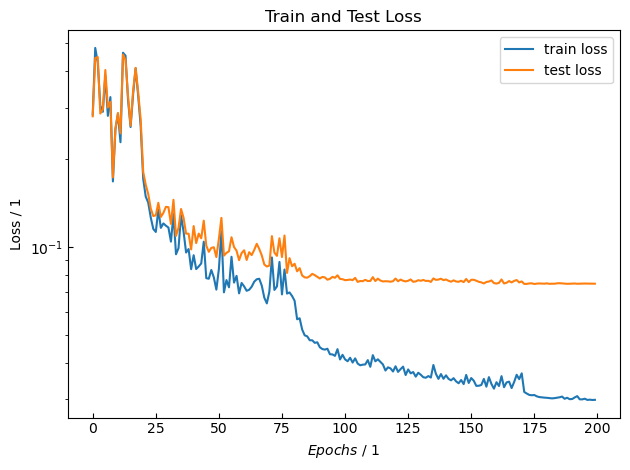

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9978123866292479 , R^2(NH3) = 0.9972330394919311
Test Dataset: R^2(H2) = 0.9926796563439405 , R^2(NH3) = 0.9872674748396643
Max Error Training: |x_H2 - x_H2,pred| = 0.0367051580051273 , |x_NH3 - x_NH3,pred| = 0.034680779549627505
Max Error Test: |x_H2 - x_H2,pred| = 0.056581875668574755 , |x_NH3 - x_NH3,pred| = 0.05910617838542637


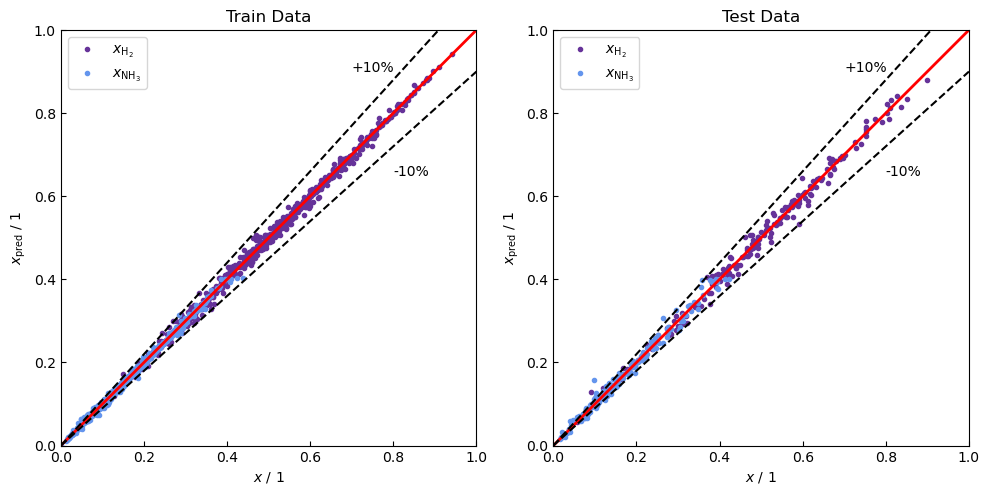

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

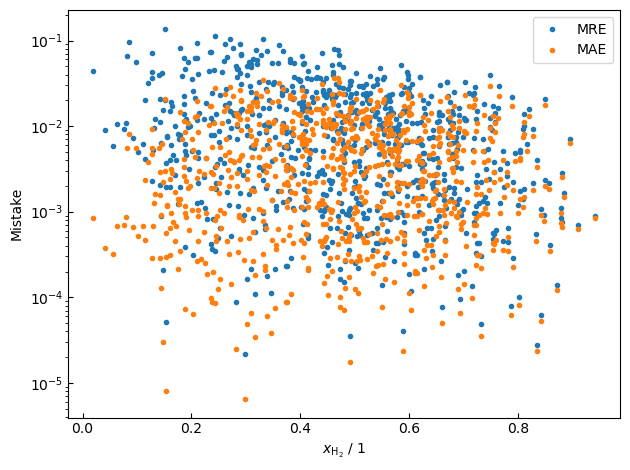

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

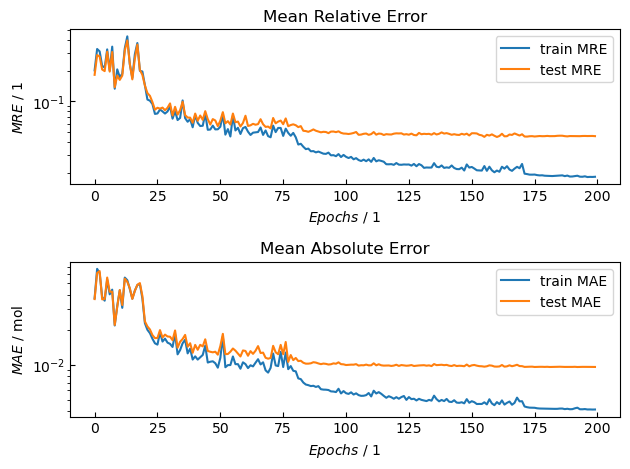

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

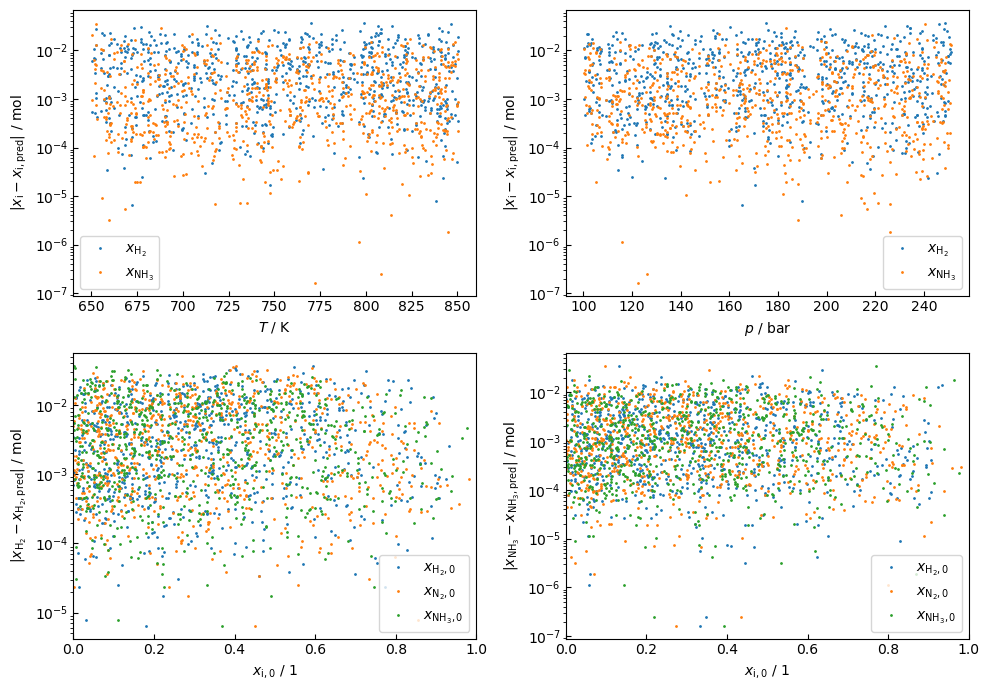

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

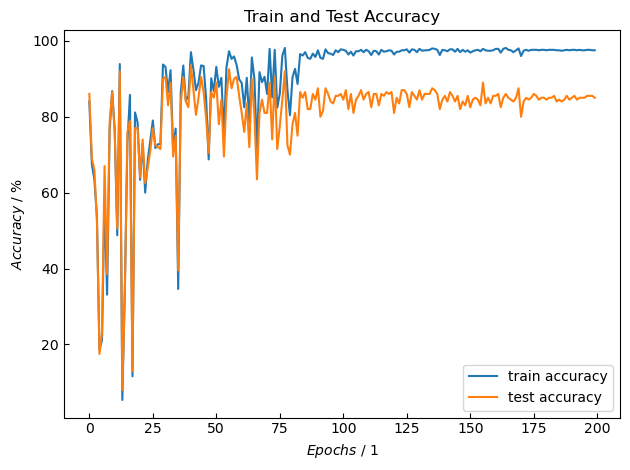

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 1.4479, -1.1421, -1.1924,  0.3080,  0.8554],
        [-1.2218,  0.3997, -0.1189, -0.8219,  0.9566],
        [-1.2486,  1.1284, -1.0758,  1.8898, -0.8757],
        [ 0.6119, -0.1599, -1.1131,  1.5945, -0.5373],
        [-0.5292,  0.0736, -0.0652, -0.9814,  1.0671],
        [-1.6305, -1.0068,  0.5909,  0.1969, -0.7811],
        [-0.3299, -1.0830, -0.2287,  0.1685,  0.0522],
        [-1.1546, -1.0749,  1.0006,  0.2316, -1.2187]])
tensor([[ 0.1232, -1.1156],
        [ 0.0126,  1.9889],
        [-1.9137, -0.6797],
        [-1.2179, -1.1453],
        [ 0.5249,  0.9114],
        [-0.6589,  1.3819],
        [-0.1189, -0.0802],
        [-0.3951,  0.7739]])
tensor([[ 0.1270, -1.1096],
        [ 0.0133,  1.9927],
        [-1.9337, -0.6557],
        [-1.2092, -1.1510],
        [ 0.4953,  0.9275],
        [-0.6567,  1.3842],
        [-0.1242, -0.0875],
        [-0.2800,  0.7518]], grad_fn=<AddmmBackward0>)


#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 7.4566e-01, -2.1529e-01, -1.1264e-01,  3.0547e-01, -1.1742e-01],
         [-6.7022e-01,  3.6339e-01, -2.9655e-01,  3.1591e-01,  4.7207e-01],
         [ 7.7100e-01, -9.5935e-01, -3.4020e-01, -9.0405e-02,  1.0254e-01],
         [ 7.7310e-01, -4.1123e-01, -8.8878e-01,  2.9120e-01,  2.8351e-01],
         [ 7.4199e-01, -3.5868e-01,  1.0692e-01,  2.8908e-01, -1.1126e-01],
         [-5.8405e-01,  5.2428e-02, -1.7060e-01,  5.1931e-01, -1.0432e-01],
         [-6.8405e-01, -3.7255e-02, -3.2586e-01,  5.2294e-01,  6.5712e-02],
         [-1.2723e-01, -1.8474e-02, -1.6744e-01,  7.3395e-01, -5.0801e-01],
         [ 2.7882e-01, -1.1449e-01, -2.4696e-01,  7.8467e-01,  2.9183e-01],
         [-2.5123e-02, -2.0975e-01, -4.5589e-01,  4.6024e-01, -6.3691e-02],
         [ 2.7071e-01, -2.9436e-01,  4.5877e-01, -7.3371e-01,  4.2357e-01],
         [ 3.5055e-01,  1.2990e-01, -3.5618e-01,  4.0280e-01, -9.6735e-02],
         [ 3.5662e-01, -2.3696e-01,  3.5058e-01, -5.3695e-01,  3.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6785, 0.9281, 0.3482, 0.5978, 0.7111],
        [0.1898, 0.5780, 0.9476, 0.2619, 0.7194]])
tensor([[ 0.1641, -0.1468],
        [ 0.1521,  0.4523]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.4450, -0.0399,  0.0185,  0.6903, -0.7237],
        [-0.8547,  0.0868, -1.3352,  0.2575,  1.0471],
        [ 0.6541,  1.6440, -1.2710,  0.8183,  0.4109],
        [ 0.2248, -0.8900, -0.9145,  1.9673, -1.1133],
        [ 0.1488,  1.3283, -0.6408,  1.3340, -0.7346],
        [ 0.9667, -1.3365,  1.5060, -1.0696, -0.3848],
        [ 0.5382,  1.4841,  0.4364, -0.1433, -0.2818],
        [-0.5127,  0.9019,  0.1235, -0.1435,  0.0255]])
tensor([-1.3878e-17,  5.5511e-17,  4.1633e-17, -5.5511e-17, -1.3878e-17],
       grad_fn=<MeanBackward1>)
tensor([[-0.8962, -0.4167,  0.3067,  0.2546, -0.7724],
        [-1.5824, -0.2960, -1.1859, -0.2321,  1.9394],
        [ 0.9449,  1.1881, -1.1152,  0.3986,  0.9652],
        [ 0.2257, -1.2269, -0.7221,  1.6907, -1.3689],
        [ 0.0984,  0.8873, -0.4203,  0.9785, -0.7891],
        [ 1.4685, -1.6524,  1.9469, -1.7244, -0.2534],
        [ 0.7507,  1.0357,  0.7675, -0.6828, -0.0957],
        [-1.0095,  0.4809,  0.4224, -0.6831,  0.3750]],
       grad_

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()